# COMP551 A1

September 30, 2025

Members: Gabriel Caballero (261108565), Adam Dufour(261193949), Charlotte Livingston (261043465)


# Installing / importing required ressources

In [ ]:
!python --version

Python 3.12.11


In [ ]:
!pip install ucimlrepo

In [ ]:
# Importing the required libraries
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score, accuracy_score, precision_score, f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats

In [ ]:
np.random.seed(551)

# Part 1: Data Cleaning

### Dataset 1: Parkinson

In [ ]:
# load dataset
parkinsons_telemonitoring = fetch_ucirepo(id=189)

target_label_parkinsons = 'motor_UPDRS'

parkinsons_variables = parkinsons_telemonitoring["variables"]
parkinsons_variables = parkinsons_variables.reset_index(drop=True)

print(parkinsons_telemonitoring.metadata)
print(parkinsons_telemonitoring.variables)
print(parkinsons_variables[["name", "role"]])

{'uci_id': 189, 'name': 'Parkinsons Telemonitoring', 'repository_url': 'https://archive.ics.uci.edu/dataset/189/parkinsons+telemonitoring', 'data_url': 'https://archive.ics.uci.edu/static/public/189/data.csv', 'abstract': "Oxford Parkinson's Disease Telemonitoring Dataset", 'area': 'Health and Medicine', 'tasks': ['Regression'], 'characteristics': ['Tabular'], 'num_instances': 5875, 'num_features': 19, 'feature_types': ['Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['motor_UPDRS', 'total_UPDRS'], 'index_col': ['subject#'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5ZS3N', 'creators': ['Athanasios Tsanas', 'Max Little'], 'intro_paper': {'ID': 229, 'type': 'NATIVE', 'title': "Accurate Telemonitoring of Parkinson's Disease Progression by Noninvasive Speech Tests", 'authors': 'A. Tsanas, Max A. Little, P. McSharry, L. Ramig', 'venue': 'IEEE Transactions on Bio

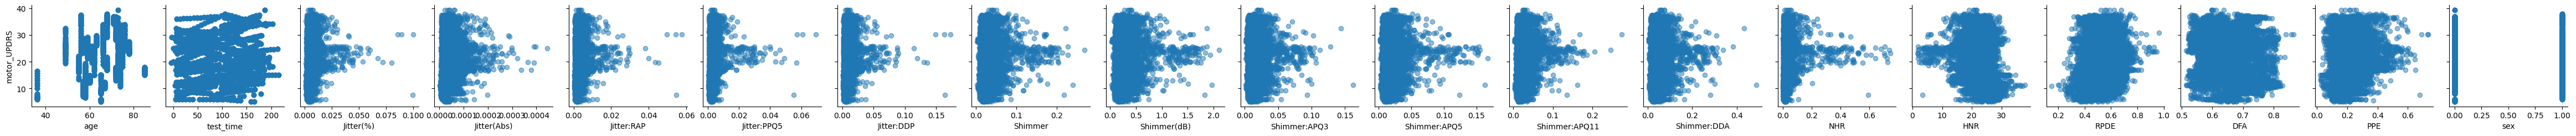

In [ ]:
parkinson_feature_cols = parkinsons_variables[parkinsons_variables['role']=='Feature']['name'].tolist()
parkinson_target_cols = parkinsons_variables[parkinsons_variables['role']=='Target']['name'].tolist()
# PairGrid style plotting
grid = sns.PairGrid(parkinsons_telemonitoring.data.original, x_vars=parkinson_feature_cols, y_vars=target_label_parkinsons)
grid.map(plt.scatter, alpha=0.5)


In [ ]:
parkinsons_df = parkinsons_telemonitoring.data.original
parkinsons_df = parkinsons_df.drop('subject#', axis=1)

print(f"Missing values found: {parkinsons_df.isnull().sum().sum()}")
parkinsons_df = parkinsons_df.dropna(how="any")

# view data (first 3 rows)
print(parkinsons_df.head(3))

Missing values found: 0
   age  sex  test_time  Jitter(%)  Jitter(Abs)  Jitter:RAP  Jitter:PPQ5  \
0   72    0     5.6431    0.00662     0.000034     0.00401      0.00317   
1   72    0    12.6660    0.00300     0.000017     0.00132      0.00150   
2   72    0    19.6810    0.00481     0.000025     0.00205      0.00208   

   Jitter:DDP  Shimmer  Shimmer(dB)  ...  Shimmer:APQ5  Shimmer:APQ11  \
0     0.01204  0.02565        0.230  ...       0.01309        0.01662   
1     0.00395  0.02024        0.179  ...       0.01072        0.01689   
2     0.00616  0.01675        0.181  ...       0.00844        0.01458   

   Shimmer:DDA       NHR     HNR     RPDE      DFA      PPE  motor_UPDRS  \
0      0.04314  0.014290  21.640  0.41888  0.54842  0.16006       28.199   
1      0.02982  0.011112  27.183  0.43493  0.56477  0.10810       28.447   
2      0.02202  0.020220  23.047  0.46222  0.54405  0.21014       28.695   

   total_UPDRS  
0       34.398  
1       34.894  
2       35.389  

[3 rows 

In [ ]:
# Compute basic statistics
basic_stats_df = parkinsons_df.describe()
print(basic_stats_df.round(3))

            age       sex  test_time  Jitter(%)  Jitter(Abs)  Jitter:RAP  \
count  5875.000  5875.000   5875.000   5875.000       5875.0    5875.000   
mean     64.805     0.318     92.864      0.006          0.0       0.003   
std       8.822     0.466     53.446      0.006          0.0       0.003   
min      36.000     0.000     -4.262      0.001          0.0       0.000   
25%      58.000     0.000     46.848      0.004          0.0       0.002   
50%      65.000     0.000     91.523      0.005          0.0       0.002   
75%      72.000     1.000    138.445      0.007          0.0       0.003   
max      85.000     1.000    215.490      0.100          0.0       0.058   

       Jitter:PPQ5  Jitter:DDP   Shimmer  Shimmer(dB)  ...  Shimmer:APQ5  \
count     5875.000    5875.000  5875.000     5875.000  ...      5875.000   
mean         0.003       0.009     0.034        0.311  ...         0.020   
std          0.004       0.009     0.026        0.230  ...         0.017   
min        

In [ ]:
# keep only the rows where all numeric values have a z-score of less than 3
numeric_cols = parkinsons_df.select_dtypes(include=np.number).columns

# stats.zscore(df[numeric_cols])) calculates the z-score of every value in the numeric_cols of the df
parkinsons_df_no_outliers = parkinsons_df[(np.abs(stats.zscore(parkinsons_df[numeric_cols])) < 3).all(axis=1)]

print(f"Shape after removing outliers: {parkinsons_df_no_outliers.shape}")
print(f"Removed {parkinsons_df.shape[0] - parkinsons_df_no_outliers.shape[0]} rows as outliers.")

Shape after removing outliers: (5505, 21)
Removed 370 rows as outliers.


In [ ]:
# Compute basic statistics without outliers
basic_stats_df = parkinsons_df_no_outliers.describe()
print(basic_stats_df.round(3))

            age       sex  test_time  Jitter(%)  Jitter(Abs)  Jitter:RAP  \
count  5505.000  5505.000   5505.000   5505.000       5505.0    5505.000   
mean     65.388     0.290     93.610      0.005          0.0       0.003   
std       8.066     0.454     53.474      0.003          0.0       0.001   
min      49.000     0.000     -4.262      0.001          0.0       0.000   
25%      58.000     0.000     47.649      0.004          0.0       0.002   
50%      66.000     0.000     93.405      0.005          0.0       0.002   
75%      72.000     1.000    139.350      0.007          0.0       0.003   
max      85.000     1.000    215.490      0.020          0.0       0.012   

       Jitter:PPQ5  Jitter:DDP   Shimmer  Shimmer(dB)  ...  Shimmer:APQ5  \
count     5505.000    5505.000  5505.000     5505.000  ...      5505.000   
mean         0.003       0.008     0.030        0.278  ...         0.018   
std          0.001       0.004     0.015        0.140  ...         0.010   
min        

In [ ]:
# separating features and targets
feat_parkinsons = parkinsons_df_no_outliers.drop(target_label_parkinsons, axis=1)
target_parkinsons = parkinsons_df_no_outliers[target_label_parkinsons]

In [ ]:
# feature scaling
scaler = StandardScaler()
cols_to_scale = [col for col in feat_parkinsons.columns if col != 'sex']

feat_parkinsons[cols_to_scale] = scaler.fit_transform(feat_parkinsons[cols_to_scale])

# one-hot encoding for categorical features
feat_parkinsons = pd.get_dummies(feat_parkinsons, columns=['sex'], drop_first=True, dtype=int) # idk if we need to one-hot encode it since 'sex' is binary here

X_parkinsons = feat_parkinsons.to_numpy()
y_parkinsons = target_parkinsons.to_numpy()

In [ ]:
# Compute basic statistics after scaling
basic_stats_df = feat_parkinsons.describe()
print(basic_stats_df.round(3))

            age  test_time  Jitter(%)  Jitter(Abs)  Jitter:RAP  Jitter:PPQ5  \
count  5505.000   5505.000   5505.000     5505.000    5505.000     5505.000   
mean      0.000     -0.000      0.000       -0.000      -0.000       -0.000   
std       1.000      1.000      1.000        1.000       1.000        1.000   
min      -2.032     -1.830     -1.707       -1.484      -1.520       -1.639   
25%      -0.916     -0.860     -0.695       -0.717      -0.688       -0.682   
50%       0.076     -0.004     -0.216       -0.245      -0.255       -0.235   
75%       0.820      0.855      0.419        0.468       0.382        0.401   
max       2.432      2.279      5.550        4.529       6.318        7.963   

       Jitter:DDP   Shimmer  Shimmer(dB)  Shimmer:APQ3  Shimmer:APQ5  \
count    5505.000  5505.000     5505.000      5505.000      5505.000   
mean       -0.000     0.000        0.000         0.000        -0.000   
std         1.000     1.000        1.000         1.000         1.000   


In [ ]:
# verification
print("Shape of final feature matrix (X):", X_parkinsons.shape)
print("Shape of final target vector (y):", y_parkinsons.shape)

print(X_parkinsons.dtype)
print(y_parkinsons.dtype)

Shape of final feature matrix (X): (5505, 20)
Shape of final target vector (y): (5505,)
float64
float64


### Dataset 2: Breast Cancer


In [ ]:
# load dataset
cancer = fetch_ucirepo(id=17)

target_label_cancer = 'Diagnosis'

cancer_variables = cancer["variables"]
cancer_variables = cancer_variables.reset_index(drop=True)

print(cancer.metadata)

{'uci_id': 17, 'name': 'Breast Cancer Wisconsin (Diagnostic)', 'repository_url': 'https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic', 'data_url': 'https://archive.ics.uci.edu/static/public/17/data.csv', 'abstract': 'Diagnostic Wisconsin Breast Cancer Database.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 569, 'num_features': 30, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Diagnosis'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1993, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5DW2B', 'creators': ['William Wolberg', 'Olvi Mangasarian', 'Nick Street', 'W. Street'], 'intro_paper': {'ID': 230, 'type': 'NATIVE', 'title': 'Nuclear feature extraction for breast tumor diagnosis', 'authors': 'W. Street, W. Wolberg, O. Mangasarian', 'venue': 'Electronic imaging', 'year': 1993, 'journal': None, 'DOI': '1

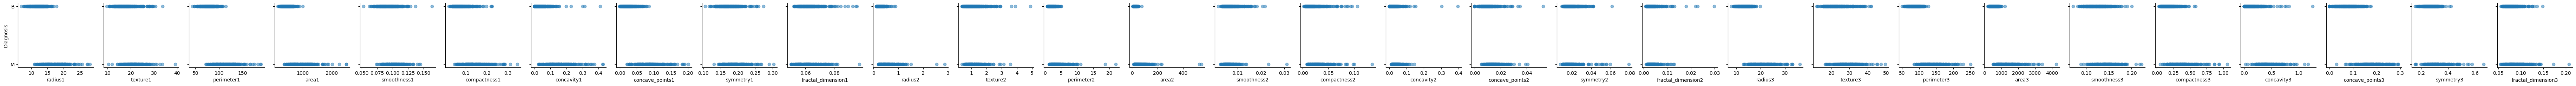

In [ ]:
cancer_feature_cols = cancer_variables[cancer_variables['role']=='Feature']['name'].tolist()
cancer_target_cols = cancer_variables[cancer_variables['role']=='Target']['name'].tolist()
# PairGrid style plotting
grid = sns.PairGrid(cancer.data.original, x_vars=cancer_feature_cols, y_vars=target_label_cancer)
grid.map(plt.scatter, alpha=0.5)

In [ ]:
cancer_df = cancer.data.original
cancer_df = cancer_df.drop('ID', axis=1)

print(f"Missing values found: {cancer_df.isnull().sum().sum()}")
cancer_df = cancer_df.dropna(how="any")

# view data (first 3 rows)
print(cancer_df.head(3))

Missing values found: 0
   radius1  texture1  perimeter1   area1  smoothness1  compactness1  \
0    17.99     10.38       122.8  1001.0      0.11840       0.27760   
1    20.57     17.77       132.9  1326.0      0.08474       0.07864   
2    19.69     21.25       130.0  1203.0      0.10960       0.15990   

   concavity1  concave_points1  symmetry1  fractal_dimension1  ...  texture3  \
0      0.3001          0.14710     0.2419             0.07871  ...     17.33   
1      0.0869          0.07017     0.1812             0.05667  ...     23.41   
2      0.1974          0.12790     0.2069             0.05999  ...     25.53   

   perimeter3   area3  smoothness3  compactness3  concavity3  concave_points3  \
0       184.6  2019.0       0.1622        0.6656      0.7119           0.2654   
1       158.8  1956.0       0.1238        0.1866      0.2416           0.1860   
2       152.5  1709.0       0.1444        0.4245      0.4504           0.2430   

   symmetry3  fractal_dimension3  Diagnosis  

In [ ]:
# Compute basic statistics
basic_stats_df = cancer_df.describe()
print(basic_stats_df.round(3))

       radius1  texture1  perimeter1     area1  smoothness1  compactness1  \
count  569.000   569.000     569.000   569.000      569.000       569.000   
mean    14.127    19.290      91.969   654.889        0.096         0.104   
std      3.524     4.301      24.299   351.914        0.014         0.053   
min      6.981     9.710      43.790   143.500        0.053         0.019   
25%     11.700    16.170      75.170   420.300        0.086         0.065   
50%     13.370    18.840      86.240   551.100        0.096         0.093   
75%     15.780    21.800     104.100   782.700        0.105         0.130   
max     28.110    39.280     188.500  2501.000        0.163         0.345   

       concavity1  concave_points1  symmetry1  fractal_dimension1  ...  \
count     569.000          569.000    569.000             569.000  ...   
mean        0.089            0.049      0.181               0.063  ...   
std         0.080            0.039      0.027               0.007  ...   
min       

In [ ]:
# keep only the rows where all numeric values have a z-score of less than 3
numeric_cols = cancer_df.select_dtypes(include=np.number).columns

# stats.zscore(df[numeric_cols])) calculates the z-score of every value in the numeric_cols of the df
cancer_df_no_outliers = cancer_df[(np.abs(stats.zscore(cancer_df[numeric_cols])) < 3).all(axis=1)]

print(f"Shape after removing outliers: {cancer_df_no_outliers.shape}")
print(f"Removed {cancer_df.shape[0] - cancer_df_no_outliers.shape[0]} rows as outliers.")

Shape after removing outliers: (495, 31)
Removed 74 rows as outliers.


In [ ]:
# Compute basic statistics without outliers
basic_stats_df = cancer_df_no_outliers.describe()
print(basic_stats_df.round(3))

       radius1  texture1  perimeter1     area1  smoothness1  compactness1  \
count  495.000   495.000     495.000   495.000      495.000       495.000   
mean    13.869    18.890      89.932   622.613        0.095         0.095   
std      3.043     3.966      20.795   286.903        0.013         0.041   
min      6.981     9.710      43.790   143.500        0.063         0.019   
25%     11.745    16.000      75.475   424.800        0.085         0.062   
50%     13.210    18.580      85.630   538.900        0.095         0.085   
75%     15.290    21.460     100.250   718.050        0.104         0.120   
max     23.270    30.720     152.100  1686.000        0.137         0.228   

       concavity1  concave_points1  symmetry1  fractal_dimension1  ...  \
count     495.000          495.000    495.000             495.000  ...   
mean        0.074            0.043      0.178               0.062  ...   
std         0.062            0.033      0.023               0.006  ...   
min       

In [ ]:
# Recoding binary target to 0 = B, 1 = M
cancer_df_no_outliers['Diagnosis'] = cancer_df_no_outliers['Diagnosis'].replace({'M': 1, 'B': 0})

# separating features and targets
feat_cancer = cancer_df_no_outliers.drop('Diagnosis', axis=1)
target_cancer = cancer_df_no_outliers['Diagnosis']

/tmp/ipython-input-1563605747.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cancer_df_no_outliers['Diagnosis'] = cancer_df_no_outliers['Diagnosis'].replace({'M': 1, 'B': 0})
/tmp/ipython-input-1563605747.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cancer_df_no_outliers['Diagnosis'] = cancer_df_no_outliers['Diagnosis'].replace({'M': 1, 'B': 0})


In [ ]:
# feature scaling
scaler = StandardScaler()
# all features are numeric, so we can scale the entire feature set directly
X_cancer = scaler.fit_transform(feat_cancer)

# one-hot encode target variable
# convert 'B' (Benign) and 'M' (Malignant) to 0 and 1
le = LabelEncoder()
y_cancer = le.fit_transform(target_cancer)

In [ ]:
# Compute basic statistics after scaling
basic_stats_df = feat_cancer.describe()
print(basic_stats_df.round(3))

       radius1  texture1  perimeter1     area1  smoothness1  compactness1  \
count  495.000   495.000     495.000   495.000      495.000       495.000   
mean    13.869    18.890      89.932   622.613        0.095         0.095   
std      3.043     3.966      20.795   286.903        0.013         0.041   
min      6.981     9.710      43.790   143.500        0.063         0.019   
25%     11.745    16.000      75.475   424.800        0.085         0.062   
50%     13.210    18.580      85.630   538.900        0.095         0.085   
75%     15.290    21.460     100.250   718.050        0.104         0.120   
max     23.270    30.720     152.100  1686.000        0.137         0.228   

       concavity1  concave_points1  symmetry1  fractal_dimension1  ...  \
count     495.000          495.000    495.000             495.000  ...   
mean        0.074            0.043      0.178               0.062  ...   
std         0.062            0.033      0.023               0.006  ...   
min       

In [ ]:
# verification
print("Shape of final feature matrix (X):", X_cancer.shape)
print("Shape of final target vector (y):", y_cancer.shape)
print("\nFirst 50 values of encoded target vector (y):")
print(y_cancer[:50])

print(X_cancer.dtype)
print(y_cancer.dtype)

Shape of final feature matrix (X): (495, 30)
Shape of final target vector (y): (495,)

First 50 values of encoded target vector (y):
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0
 1 0 0 0 0 0 1 1 0 1 1 0 0]
float64
int64


# PART 2: Models


### Linear Regression Class

In [ ]:
class LinearRegression:
    def __init__(self, regularization=None, lamb=1.0):
        """
        regularization : str, either None or 'L2'
        lamb : float, regularization strength (lambda)
        """
        self.regularization = regularization
        self.lamb = lamb
        self.coefficients = None

    def fit(self, x, y):
        """
        Fit the linear regression model to the training data.

        x : np.array, shape (n_samples, n_features)
        y : np.array, shape (n_samples,)
        """
        #y = y.flatten()

        # Add bias term (column of ones) basically the intercept of the linear line
        x_bias = np.c_[np.ones(x.shape[0], dtype=np.float64), x]

        if self.regularization == 'L2':
            # Identity matrix for regularization (don’t regularize bias)
            ind = np.identity(x_bias.shape[1])
            ind[0, 0] = 0

            # Closed form with ridge: (X^T X + λI)^(-1) X^T y
            self.coefficients = (
                np.linalg.pinv(x_bias.T @ x_bias + self.lamb * ind) @ x_bias.T @ y
            )
        else:
            # Standard closed form: (X^T X)^(-1) X^T y
            self.coefficients = (
                np.linalg.pinv(x_bias.T @ x_bias) @ x_bias.T @ y
            )

    def predict(self, x):
        """
        Predict output for given input features.

        x : np.array, shape (n_samples, n_features)
        """
        x_bias = np.c_[np.ones(x.shape[0], dtype=np.float64), x]
        return x_bias @ self.coefficients


### Logistic Regression

In [ ]:
class LogisticRegression:
    def __init__(self, learning_rate=0.1, max_iters=1e5, epsilon=1e-4, regularization=None, lamb=1.0):
        self.weights = None
        self.learning_rate = learning_rate
        self.max_iters = int(max_iters)
        self.epsilon = epsilon
        self.regularization = regularization
        self.lamb = lamb

    def sigmoid(self, z):
        """
        logistic function
        """
        # prevent overflow issues
        z = np.clip(z, -500,500)
        p = 1 / (1 + np.exp(-z))
        return np.clip(p, 1e-15, 1 - 1e-15)

    def gradient(self, x, y):
        N, D = x.shape

        y_predicted = self.sigmoid(np.dot(x, self.weights))
        grad = np.dot(x.T, y_predicted - y) / N

        if self.regularization == 'L2':
            reg_term = self.weights.copy()
            reg_term[0] = 0 # dont regularize the bias term
            grad += self.lamb * reg_term

        return grad

    def fit(self, x, y):
        """
        fit the logistic regression model to the training data

        x : np.array, shape (n_samples, n_features)
        y : np.array, shape (n_samples,)
        """
        n_samples, n_features = x.shape

        y = y.flatten()

        # add bias term (column of ones) basically the intercept of the linear line
        x_bias = np.c_[np.ones(n_samples), x]

        N, D = x_bias.shape

        self.weights = np.zeros(D)

        # gradient descent loop
        for _ in range(self.max_iters):
            gradient = self.gradient(x_bias, y)

            if np.linalg.norm(gradient) <= self.epsilon:
                break

            self.weights -= self.learning_rate * gradient

        self.coefficients = self.weights ## Final weights = model coefficents

    def predict_probability(self, x):
        """
        Predicts the probability of belonging to class 1
        """
        # Add bias term (column of ones) to beginning of input features
        x = np.c_[np.ones(x.shape[0]), x]

        # Calculate predictions using the weights
        return self.sigmoid(x.dot(self.weights))

    def predict(self, x):
        """
        Predicts the class label (0 or 1)
        """
        probabilities = self.predict_probability(x)

        # Use a boundary of 0.5 to separate binary 0s and 1s
        y_pred = (probabilities > 0.5).astype(int)
        return y_pred


### Linear Regression with Mini-Batch SGD

In [ ]:
class LinearRegressionSGD:
    def __init__(self, learning_rate=0.1, max_iters=100, batch_size=32, regularization=None, lamb=1.0, epsilon=1e-4):
        """
        learning_rate : float, step size for gradient descent
        max_iters : int, max number of passes over training data
        batch_size : int, number of samples per batch
        regularization : str, either None or 'L2'
        lamb : float, regularization strength (lambda)
        """
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.batch_size = batch_size
        self.regularization = regularization
        self.lamb = lamb
        self.coefficients = None
        self.epsilon = epsilon
        self.convergence_iter = None

    def gradient(self, x_batch, y_batch):
        n_samples = x_batch.shape[0]
        y_predicted = np.dot(x_batch, self.coefficients)
        error = y_predicted - y_batch
        grad = (1 / n_samples) * np.dot(x_batch.T, error)

        if self.regularization == 'L2':
            reg_term = self.coefficients.copy()
            reg_term[0] = 0 # dont regularize the bias term
            grad += self.lamb * reg_term

        return grad

    def fit(self, x, y):
        """
        Fit the linear regression model to the training data.

        x : np.array, shape (n_samples, n_features)
        y : np.array, shape (n_samples,)
        """
        y = y.flatten()

        # Add bias term (column of ones) basically the intercept of the linear line
        x_bias = np.c_[np.ones(x.shape[0], dtype=np.float64), x]
        n_samples, n_features = x_bias.shape
        self.coefficients = np.zeros(n_features)

        for j in range(self.max_iters):
            indices = np.random.permutation(n_samples)
            x_shuffled = x_bias[indices]
            y_shuffled = y[indices]

            prev_coefficents = self.coefficients.copy()

            for i in range(0, n_samples, self.batch_size):
                x_batch = x_shuffled[i : i + self.batch_size]
                y_batch = y_shuffled[i : i + self.batch_size]
                gradient = self.gradient(x_batch, y_batch)
                self.coefficients -= self.learning_rate * gradient

            ## Stop early due to convergence:
            if abs(np.linalg.norm(self.coefficients - prev_coefficents)) < self.epsilon:
              self.convergence_iter = j
              # print("Converged after", j, "iterations")
              break

            if j == self.max_iters - 1:
              self.convergence_iter = self.max_iters
              #print("Did not converge after", self.max_iters, "iterations")

    def predict(self, x):
        """
        Predict output for given input features.

        x : np.array, shape (n_samples, n_features)
        """
        x_bias = np.c_[np.ones(x.shape[0], dtype=np.float64), x]
        return x_bias @ self.coefficients


### Logistic Regression with Mini-Batch SGD

In [ ]:
class LogisticRegressionSGD:
    def __init__(self, learning_rate=0.1, max_iters=100, batch_size=32, regularization=None, lamb=1.0, epsilon=1e-4):
        self.weights = None
        self.learning_rate = learning_rate
        self.max_iters = int(max_iters)
        self.batch_size = batch_size
        self.regularization = regularization
        self.lamb = lamb
        self.epsilon = epsilon
        self.convergence_iter = None

    def sigmoid(self, z):
        """
        logistic function
        """
        # prevent overflow issues
        z = np.clip(z, -500,500)
        p = 1 / (1 + np.exp(-z))
        return np.clip(p, 1e-15, 1 - 1e-15)

    def gradient(self, x, y):
        N, D = x.shape

        y_predicted = self.sigmoid(np.dot(x, self.weights))
        grad = np.dot(x.T, y_predicted - y) / N

        if self.regularization == 'L2':
            reg_term = self.weights.copy()
            reg_term[0] = 0 # dont regularize the bias term
            grad += self.lamb * reg_term

        return grad

    def fit(self, x, y):
        """
        fit the logistic regression model using mini-batch gradient descent

        x : np.array, shape (n_samples, n_features)
        y : np.array, shape (n_samples,)
        """
        n_samples, n_features = x.shape

        y = y.flatten()

        # add bias term (column of ones) basically the intercept of the linear line
        x_bias = np.c_[np.ones(n_samples), x]

        N, D = x_bias.shape

        self.weights = np.zeros(D)

        for j in range(self.max_iters):
            indices = np.random.permutation(n_samples)
            x_shuffled = x_bias[indices]
            y_shuffled = y[indices]

            prev_weights = self.weights.copy()

            for i in range(0, n_samples, self.batch_size):
                x_batch = x_shuffled[i : i + self.batch_size]
                y_batch = y_shuffled[i : i + self.batch_size]

                gradient = self.gradient(x_batch, y_batch)
                self.weights -= self.learning_rate * gradient

            ## Stop early due to convergence:
            if abs(np.linalg.norm(self.weights - prev_weights)) < self.epsilon:
              self.convergence_iter = j
              print("Converged after", j, "iterations")
              break

            if j == self.max_iters - 1:
              self.convergence_iter = self.max_iters
              # print("Did not converge after", self.max_iters, "iterations")

    def predict_probability(self, x):
        """
        Predicts the probability of belonging to class 1
        """
        # Add bias term (column of ones) to beginning of input features
        x = np.c_[np.ones(x.shape[0]), x]

        # Calculate predictions using the weights
        return self.sigmoid(x.dot(self.weights))

    def predict(self, x):
        """
        Predicts the class label (0 or 1)
        """
        probabilities = self.predict_probability(x)

        # Use a boundary of 0.5 to separate binary 0s and 1s
        y_pred = (probabilities > 0.5).astype(int)
        return y_pred

In [ ]:
### Create Polynomial Features

In [ ]:
def create_polynomial_features(X):
  # x: original feature matrix of shape (n_samples, n_features)
  n_samples, n_features = X.shape

  features = [X] # original ones

  # quadratic features (x_i^2)
  for i in range(n_features):
    quad_feature = (X[:, i] ** 2).reshape(-1, 1)
    features.append(quad_feature)

  # interaction features (x_i * x_j for i < j)
  for i in range(n_features):
    for j in range(i + 1, n_features):
      interaction_feature = (X[:, i] * X[:, j]).reshape(-1, 1)
      features.append(interaction_feature)

  # stack all feature columns into a single new matrix
  return np.hstack(features)

# Part 3 basic:
Just quick testing to make sure models work (just here as a sanity check, proper testing follow in the next section)

## Linear Regression Test DS1

### Normal Linear Regression

In [ ]:
# split traing/test dataset (80/20)
X_train, X_test, y_train, y_test = train_test_split(X_parkinsons, y_parkinsons, test_size=0.2)

In [ ]:
# fit model
lir_model = LinearRegression()
lir_model.fit(X_train, y_train)

# predict targets
y_train_pred = lir_model.predict(X_train)
y_test_pred = lir_model.predict(X_test)

# calculate RMSE
train_rmse = root_mean_squared_error(y_train, y_train_pred)
test_rmse = root_mean_squared_error(y_test, y_test_pred)

# calculate R^2
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
print("Train R^2:", train_r2)
print("Test R^2:", test_r2)

Train RMSE: 2.4251213584720657
Test RMSE: 2.4754969180533033
Train R^2: 0.9117034324465592
Test R^2: 0.9040032855644029


### Linear Regression with SGD

In [ ]:
# fit model
lirSGD_model = LinearRegressionSGD()
lirSGD_model.fit(X_train, y_train)

# predict targets
y_train_pred = lirSGD_model.predict(X_train)
y_test_pred = lirSGD_model.predict(X_test)

# calculate RMSE
train_rmse = root_mean_squared_error(y_train, y_train_pred)
test_rmse = root_mean_squared_error(y_test, y_test_pred)

# calculate R^2
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
print("Train R^2:", train_r2)
print("Test R^2:", test_r2)

Train RMSE: 2.5291337122162685
Test RMSE: 2.582277278323237
Train R^2: 0.9039670103814211
Test R^2: 0.895543050936835


## Logistic Regression Test DS2

In [ ]:
# split traing/test dataset (80/20)
X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, test_size=0.2)

### Normal Logistic Regression

In [ ]:
# fit model
log_model = LogisticRegression()
log_model.fit(X_train, y_train)

# predict targets
y_train_pred = log_model.predict(X_train)
y_test_pred = log_model.predict(X_test)

print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

print("Train Precision:", precision_score(y_train, y_train_pred))
print("Test Precision:", precision_score(y_test, y_test_pred))

Train Accuracy: 1.0
Test Accuracy: 0.9494949494949495
Train Precision: 1.0
Test Precision: 0.96875


### Logistic Regression with SGD

In [ ]:
# fit model
logSGD_model = LogisticRegressionSGD()
logSGD_model.fit(X_train, y_train)

# predict targets
y_train_pred = logSGD_model.predict(X_train)
y_test_pred = logSGD_model.predict(X_test)

print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

print("Train Precision:", precision_score(y_train, y_train_pred))
print("Test Precision:", precision_score(y_test, y_test_pred))

Train Accuracy: 0.9924242424242424
Test Accuracy: 0.9595959595959596
Train Precision: 1.0
Test Precision: 0.9696969696969697


# Part 3: Testing

## Test Class:

In [ ]:
## Metrics Class to help with Data visualization

class metrics:
  def split_data(X, output, p_test, seed):
    """
    X : np.array, shape (n_samples, n_features)
    p_test : float, proportion of data to be used for testing

    Return:
    np.arrays: X_train, y_train, X_test, y_test
    """
    n = X.shape[0]
    test_size = int(n * p_test)
    train_size = n - test_size
    np.random.seed(seed)
    indices = np.random.permutation(n)
    test_ind = indices[:test_size]
    train_ind = indices[test_size:]
    return np.array(X[train_ind,:]), np.array(output[train_ind]).flatten(), np.array(X[test_ind,:]), np.array(output[test_ind]).flatten()

  def make_confusion_matrix(true,pred):
    con_matrix = np.zeros(shape=(2,2), dtype=float)
    for i in range(len(true)):
      con_matrix[true[i]][pred[i]] += 1
    return con_matrix

    """
    Return: matrix
    Format: axis 0 = true, axis 1 = predicted
        AKA --> [0][0] = True Negative, [0][1] = False Positive,
                [1][0] = False Negative, [1][1] = True Positive
    """

  def get_MSE(true,pred):
    score = 0
    for i in range(len(true)):
      score += (true[i] - pred[i])**2
    score = score/len(true)
    return score

  def get_R2(true, pred):
    ssr,sst = 0,0
    mean = np.mean(true)
    for i in range(len(true)):
      ssr += (true[i] - pred[i])**2
      sst += (true[i] - mean)**2
    if sst == 0:
      score = 1
      print("Warning: sst = 0, no variation in true labels")
    else:
      score = 1 - (ssr/sst)
    return score

  def get_RMSE(true,pred):
    score = 0
    for i in range(len(true)):
      score += (true[i] - pred[i])**2
    score = np.sqrt(score/len(true))
    return score

  def get_metrics_regression(true,pred,print_metrics=True):
    r2_score = metrics.get_R2(true,pred)
    mse = metrics.get_MSE(true,pred)
    rmse = metrics.get_RMSE(true,pred)
    if print_metrics:
      print("R2: ", r2_score)
      print("RMSE: ", rmse)
      print("MSE: ", mse)

    return np.array([r2_score,rmse,mse])

  def get_metrics_classification(true,pred,print_metrics=True):
    con_matrix = metrics.make_confusion_matrix(true,pred)

    # Calculate recall: TP/(TP+FN)
    recall_score = con_matrix[1][1] / (con_matrix[1][1] + con_matrix[1][0])

    # Calculate precision: TP/(TP+FP)
    precision_score = con_matrix[1][1] / (con_matrix[1][1] + con_matrix[0][1])

    # Calculate F1 score: 2*recall*precision/(precision+recall)
    f1_score = 2 * (precision_score * recall_score) / (precision_score + recall_score)

    # Calculate accuracy: TP+TN/total
    accuracy_score = (con_matrix[0][0] + con_matrix[1][1]) / con_matrix.sum()

    if print_metrics:
      print("Confusion Matrix: \n", con_matrix)
      print("Precision: ", precision_score)
      print("Recall: ", recall_score)
      print("F1 Score: ", f1_score)
      print("Accuracy: ", accuracy_score)

    return np.array([precision_score,recall_score,f1_score,accuracy_score])


In [ ]:
my_seed = np.random.randint(1000)
print("My seed: ", my_seed)

My seed:  951


## Linear Regression for Regression

### Basic Testing

In [ ]:
## Collect train/test sets
train_set_1, train_output_1, test_set_1, test_output_1 = metrics.split_data(X_parkinsons, y_parkinsons, 0.2, seed=my_seed)

## Train model
linear_reg_model_1 = LinearRegression(regularization=None, lamb=1.0)
linear_reg_model_1.fit(train_set_1, train_output_1)

## Return
print("Coefficents: \n", linear_reg_model_1.coefficients) ## skip bias

## Predict
y_lin_trainset_1 = linear_reg_model_1.predict(train_set_1)
y_lin_testset_1 = linear_reg_model_1.predict(test_set_1)

## Evaluate Performance
print("\nPerformance on Train_set:")
temp = metrics.get_metrics_regression(train_output_1, y_lin_trainset_1)
print("\nPerformance on Test_set:")
temp = metrics.get_metrics_regression(test_output_1, y_lin_testset_1)

Coefficents: 
 [ 2.13371170e+01 -4.01541209e-01  1.34572356e-02  2.05316535e+00
 -1.83100847e+00 -1.28545786e+01  7.49341967e-01  1.17515567e+01
  2.25643216e+00 -6.72442609e-01  2.16318580e+02 -1.90780680e+00
  1.02364326e+00 -2.16856663e+02 -8.02340039e-02  6.87036798e-03
 -5.44503067e-02 -1.55432180e-01  7.34266980e-02  7.62091954e+00
  2.98527524e-01]

Performance on Train_set:
R2:  0.9099436352224191
RMSE:  2.4316113506895882
MSE:  5.9127337608024435

Performance on Test_set:
R2:  0.9113230402267929
RMSE:  2.448702397643869
MSE:  5.996143432226831


We see a good correlation since we added motor_UPDRS to the labels and we have not dropped it.

### Preformance Relative to Train/Test Proportion

In [ ]:
testset_sizes = np.arange(0.9, 0, -0.1) ## proportions of dataset reserved for testset
n_iterations = 20

performance_lin = np.zeros((2, 3, len(testset_sizes), n_iterations))

for i in range(len(testset_sizes)):
  test_size = testset_sizes[i]

  for j in range(n_iterations): ## 20 permutations
    ## Isolate training and test sets
    train_set, train_output, test_set, test_output = metrics.split_data(X_parkinsons, y_parkinsons, test_size, seed=(my_seed+j))

    ## Fit models
    linear_reg_model = LinearRegression(regularization=None, lamb=1.0)
    linear_reg_model.fit(train_set, train_output)

    ## Make prediction
    y_lin_train = linear_reg_model.predict(train_set)
    y_lin_test = linear_reg_model.predict(test_set)

    ## Evaluate Performance:

    # Linear preformance on trainset
    performance_lin[0,:,i,j] = metrics.get_metrics_regression(train_output, y_lin_train, print_metrics = False)

    # Linear preformance on testset
    performance_lin[1,:,i,j] = metrics.get_metrics_regression(test_output, y_lin_test, print_metrics = False)


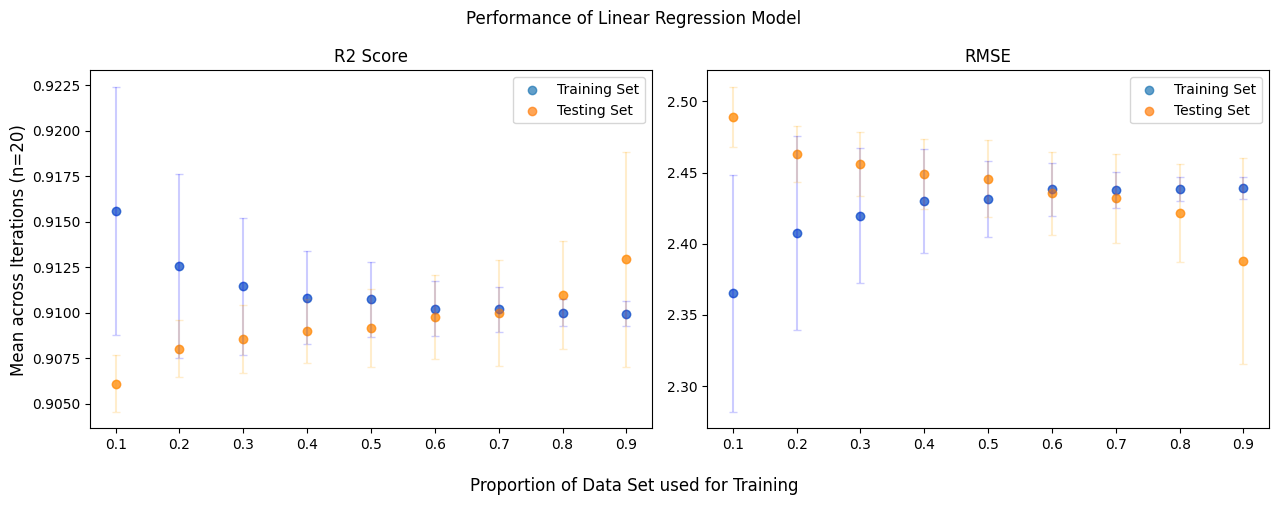

In [ ]:
## Plotting for Linear Regression Evaluation
fig, axs = plt.subplots(1, 2, figsize=(13,5))
mets = ["R2 Score", "RMSE"]
train_sizes = 1 - testset_sizes

for met, ax in enumerate(axs):

    # Calculate mean and std accross the iterations
    train_mean = performance_lin[0,met].mean(axis=1)
    train_std = performance_lin[0,met].std(axis=1)

    test_mean = performance_lin[1,met].mean(axis=1)
    test_std = performance_lin[1,met].std(axis=1)

    # Plot
    ax.scatter(train_sizes, train_mean, label="Training Set", alpha=0.7)
    ax.errorbar(train_sizes, train_mean, yerr=train_std, fmt='o', color='blue', alpha=0.2, capsize=3)
    ax.scatter(train_sizes, test_mean, label="Testing Set", alpha=0.7)
    ax.errorbar(train_sizes, test_mean, yerr=test_std, fmt='o', color='orange', alpha=0.2, capsize=3)
    ax.set_title(mets[met])
    ax.legend()


fig.supylabel("Mean across Iterations (n=20)")
fig.supxlabel("Proportion of Data Set used for Training")
fig.suptitle("Performance of Linear Regression Model")
fig.tight_layout()
fig.show()

### Adding Polynomial Features

In [ ]:
n_iterations = 5

basic_r2_scores = np.zeros(n_iterations)
basic_rmse_scores = np.zeros(n_iterations)
poly_r2_scores = np.zeros(n_iterations)
poly_rmse_scores = np.zeros(n_iterations)

for i in range(n_iterations):
  X_train, y_train, X_test, y_test = metrics.split_data(X_parkinsons, y_parkinsons, 0.2, seed=my_seed+i+551)

  # basic Linear Regression Model
  basic_model = LinearRegression()
  basic_model.fit(X_train, y_train)
  y_pred_basic = basic_model.predict(X_test)

  basic_metrics = metrics.get_metrics_regression(y_test, y_pred_basic, print_metrics=False)
  basic_r2_scores[i] = basic_metrics[0]
  basic_rmse_scores[i] = basic_metrics[1]

  # polynomial Linear Regression Model
  X_train_poly = create_polynomial_features(X_train)
  X_test_poly = create_polynomial_features(X_test)

  poly_model = LinearRegression()
  poly_model.fit(X_train_poly, y_train)
  y_pred_poly = poly_model.predict(X_test_poly)
  poly_metrics = metrics.get_metrics_regression(y_test, y_pred_poly, print_metrics=False)
  poly_r2_scores[i] = poly_metrics[0]
  poly_rmse_scores[i] = poly_metrics[1]

Basic Model Avg. R^2:   0.9103 (+- 0.0044)
Basic Model Avg. RMSE: 2.4359 (+- 0.0554)

Poly. Model Avg. R^2:   0.9449 (+- 0.0031)
Poly. Model Avg. RMSE: 1.9091 (+- 0.0531)


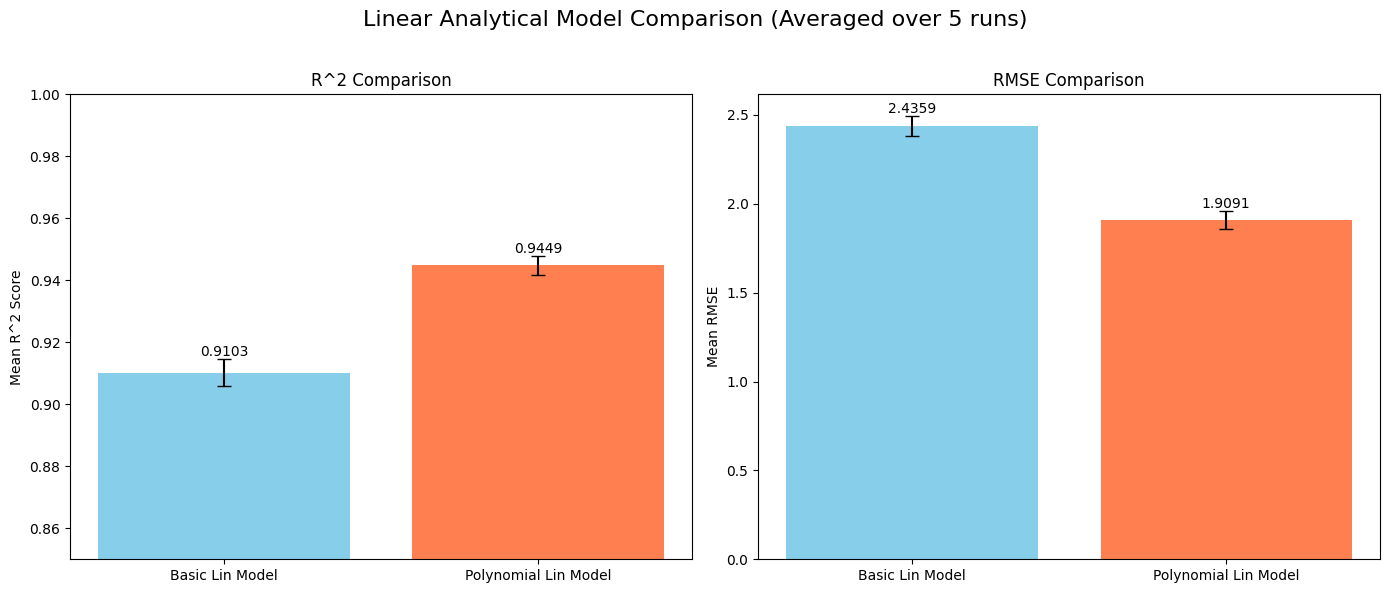

In [ ]:
print(f"Basic Model Avg. R^2:   {np.mean(basic_r2_scores):.4f} (+- {np.std(basic_r2_scores):.4f})")
print(f"Basic Model Avg. RMSE: {np.mean(basic_rmse_scores):.4f} (+- {np.std(basic_rmse_scores):.4f})\n")
print(f"Poly. Model Avg. R^2:   {np.mean(poly_r2_scores):.4f} (+- {np.std(poly_r2_scores):.4f})")
print(f"Poly. Model Avg. RMSE: {np.mean(poly_rmse_scores):.4f} (+- {np.std(poly_rmse_scores):.4f})")

model_names = ['Basic Lin Model', 'Polynomial Lin Model']
mean_r2 = [np.mean(basic_r2_scores), np.mean(poly_r2_scores)]
std_r2 = [np.std(basic_r2_scores), np.std(poly_r2_scores)]
mean_rmse = [np.mean(basic_rmse_scores), np.mean(poly_rmse_scores)]
std_rmse = [np.std(basic_rmse_scores), np.std(poly_rmse_scores)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
bars1 = ax1.bar(model_names, mean_r2, yerr=std_r2, color=['skyblue', 'coral'], capsize=5)
ax1.bar_label(bars1, fmt='%.4f')
ax1.set_ylabel('Mean R^2 Score')
ax1.set_title('R^2 Comparison')
ax1.set_ylim(bottom=0.85, top=1.0)

bars2 = ax2.bar(model_names, mean_rmse, yerr=std_rmse, color=['skyblue', 'coral'], capsize=5)
ax2.bar_label(bars2, fmt='%.4f')
ax2.set_ylabel('Mean RMSE')
ax2.set_title('RMSE Comparison')
fig.suptitle(f'Linear Analytical Model Comparison (Averaged over {n_iterations} runs)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('linear_comparison_plot_custom_metrics.png')
plt.show()

## Logistic Regression for Classification

In [ ]:
## Collect Training Data
train_set_2, train_output_2, test_set_2, test_output_2 = metrics.split_data(X_cancer, y_cancer, 0.2, seed=my_seed)

## Train model
log_reg_model = LogisticRegression(regularization=None, lamb=1.0)
log_reg_model.fit(train_set_2, train_output_2)

## Return
print("Coefficents: \n", log_reg_model.coefficients) ## skip bias

## Predict
y_log_trainset_2 = log_reg_model.predict(train_set_2)
y_log_testset_2 = log_reg_model.predict(test_set_2)

## Evaluate Performance
print("\nPerformance on Train_set:")
temp = metrics.get_metrics_classification(train_output_2, y_log_trainset_2)
print("\nPerformance on Test_set:")
temp = metrics.get_metrics_classification(test_output_2, y_log_testset_2)



Coefficents: 
 [-1.52301045 -2.24092935  1.56088133 -1.48199575 -0.19077108 -0.31738411
 -6.49075961  6.77533795  6.27630894 -0.49479692  3.37505519  3.40168885
 -1.00933268  2.28070927  4.76773194 -1.88766856 -2.45144987 -0.05256786
  1.58050801 -2.3474377  -4.26661412  2.19266717  2.87233545  3.23290198
  3.68791557  1.19426716 -2.73317958  2.12386085  2.91571884  3.12024335
  3.32226148]

Performance on Train_set:
Confusion Matrix: 
 [[257.   2.]
 [  3. 134.]]
Precision:  0.9852941176470589
Recall:  0.9781021897810219
F1 Score:  0.9816849816849818
Accuracy:  0.9873737373737373

Performance on Test_set:
Confusion Matrix: 
 [[73.  0.]
 [ 1. 25.]]
Precision:  1.0
Recall:  0.9615384615384616
F1 Score:  0.9803921568627451
Accuracy:  0.98989898989899


### Preformance Relative to Train/Test Proportion


In [ ]:
testset_sizes = np.arange(0.9, 0, -0.1) ## proportions of dataset reserved for testset
n_iterations = 20

performance_log = np.zeros((2, 4, len(testset_sizes), n_iterations)) #4 metrics to keep track of for classification

for i in range(len(testset_sizes)):
  test_size = testset_sizes[i]

  for j in range(n_iterations): ## 20 permutations
    ## Isolate training and test sets
    train_set, train_output, test_set, test_output = metrics.split_data(X_cancer, y_cancer, test_size, seed=(my_seed+j))

    ## Fit model
    log_reg_model = LogisticRegression(regularization=None, lamb=1.0)
    log_reg_model.fit(train_set, train_output)

    ## Make prediction
    y_log_train = log_reg_model.predict(train_set)
    y_log_test = log_reg_model.predict(test_set)

    ## Evaluate:
    performance_log[0,:,i,j] = metrics.get_metrics_classification(train_output, y_log_train, print_metrics = False)
    performance_log[1,:,i,j] = metrics.get_metrics_classification(test_output, y_log_test, print_metrics = False)

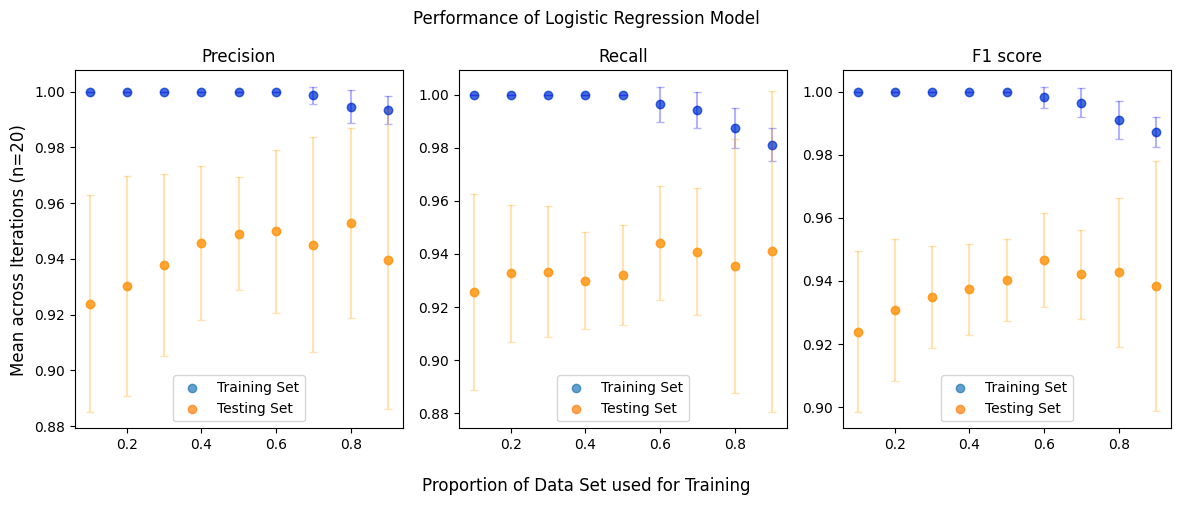

In [ ]:
## Plotting for Logistic Regression for Classification Evaluation
fig, axs = plt.subplots(1, 3, figsize=(12,5))
mets = ["Precision","Recall","F1 score"]
train_sizes = 1 - testset_sizes

for met, ax in enumerate(axs):

    # Calculate mean and std accross the iterations
    train_mean = performance_log[0,met].mean(axis=1)
    train_std = performance_log[0,met].std(axis=1)

    test_mean = performance_log[1,met].mean(axis=1)
    test_std = performance_log[1,met].std(axis=1)

    # Plot
    ax.scatter(train_sizes, train_mean, label="Training Set", alpha=0.7)
    ax.errorbar(train_sizes, train_mean, yerr=train_std, fmt='o', color='blue', alpha=0.3, capsize=3)
    ax.scatter(train_sizes, test_mean, label="Testing Set", alpha=0.7)
    ax.errorbar(train_sizes, test_mean, yerr=test_std, fmt='o', color='orange', alpha=0.3, capsize=3)
    ax.set_title(mets[met])
    ax.legend()

fig.supylabel("Mean across Iterations (n=20)")
fig.supxlabel("Proportion of Data Set used for Training")
fig.suptitle("Performance of Logistic Regression Model")
fig.tight_layout()
fig.show()


### Adding Polynomial Features

In [ ]:
n_iterations = 5

basic_accuracies = np.zeros(n_iterations)
poly_accuracies = np.zeros(n_iterations)

for i in range(n_iterations):
  X_train, y_train, X_test, y_test = metrics.split_data(X_cancer, y_cancer, 0.2, seed=my_seed+i)

  # basic Logistic Regression Model
  basic_model = LogisticRegression()
  basic_model.fit(X_train, y_train)
  y_pred_basic = basic_model.predict(X_test)
  basic_accuracies[i] = accuracy_score(y_test, y_pred_basic)

  # polynomial Logistic Regression Model
  X_train_poly = create_polynomial_features(X_train)
  X_test_poly = create_polynomial_features(X_test)

  poly_model = LogisticRegression()
  poly_model.fit(X_train_poly, y_train)
  y_pred_poly = poly_model.predict(X_test_poly)
  poly_accuracies[i] = accuracy_score(y_test, y_pred_poly)

Basic Model Average Accuracy: 0.9697 (+- 0.0111)
Polynomial Model Average Accuracy: 0.9495 (+- 0.0230)


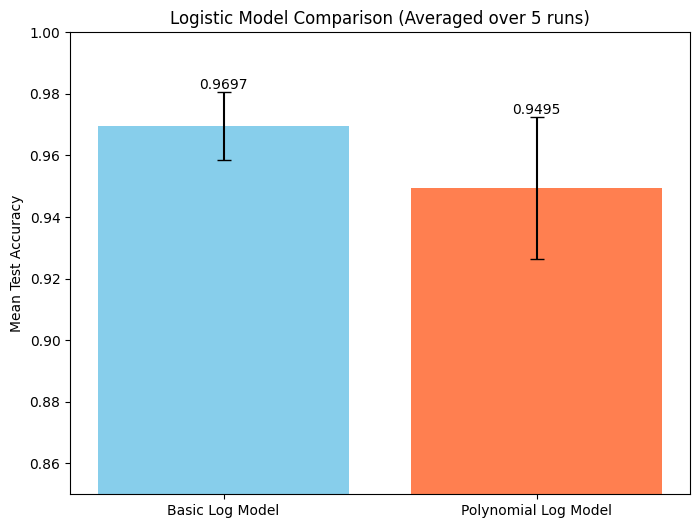

In [ ]:
mean_basic_acc = np.mean(basic_accuracies)
std_basic_acc = np.std(basic_accuracies)

mean_poly_acc = np.mean(poly_accuracies)
std_poly_acc = np.std(poly_accuracies)

print(f"Basic Model Average Accuracy: {mean_basic_acc:.4f} (+- {std_basic_acc:.4f})")
print(f"Polynomial Model Average Accuracy: {mean_poly_acc:.4f} (+- {std_poly_acc:.4f})")

model_names = ['Basic Log Model', 'Polynomial Log Model']
mean_accuracies = [mean_basic_acc, mean_poly_acc]
std_accuracies = [std_basic_acc, std_poly_acc]

plt.figure(figsize=(8, 6))
# https://matplotlib.org/stable/gallery/color/named_colors.html (cool colors ref)
bars = plt.bar(model_names, mean_accuracies, yerr=std_accuracies, color=['skyblue', 'coral'], capsize=5)

plt.ylabel('Mean Test Accuracy')
plt.title(f'Logistic Model Comparison (Averaged over {n_iterations} runs)')
plt.ylim(bottom=0.85, top=1)
plt.bar_label(bars, fmt='%.4f')
plt.savefig('logistic_comparison_plot.png')

## Linear Regression with SGD for Regression

### Analytical Linear Regression vs SGD Linear Regression

In [ ]:
## Collect train/test sets
train_set, train_output, test_set, test_output = metrics.split_data(X_parkinsons, y_parkinsons, 0.2, seed=my_seed)

# Get Analytical Model Results
analytical_model = LinearRegression()
analytical_model.fit(train_set, train_output)
y_pred_analytical = analytical_model.predict(test_set)

print("\nPerformance on Test_set Analytical:")
scores_analytical = metrics.get_metrics_regression(y_pred_analytical, test_output)

sgd_model = LinearRegressionSGD()
sgd_model.fit(train_set, train_output)
y_pred_sgd = sgd_model.predict(test_set)

print("\nPerformance on Test_set SGD")
scores_sgd = metrics.get_metrics_regression(y_pred_sgd, test_output)


Performance on Test_set Analytical:
R2:  0.9018720480731035
RMSE:  2.448702397643869
MSE:  5.996143432226831

Performance on Test_set SGD
R2:  0.8971556659059717
RMSE:  2.4623664035606763
MSE:  6.063248305384339


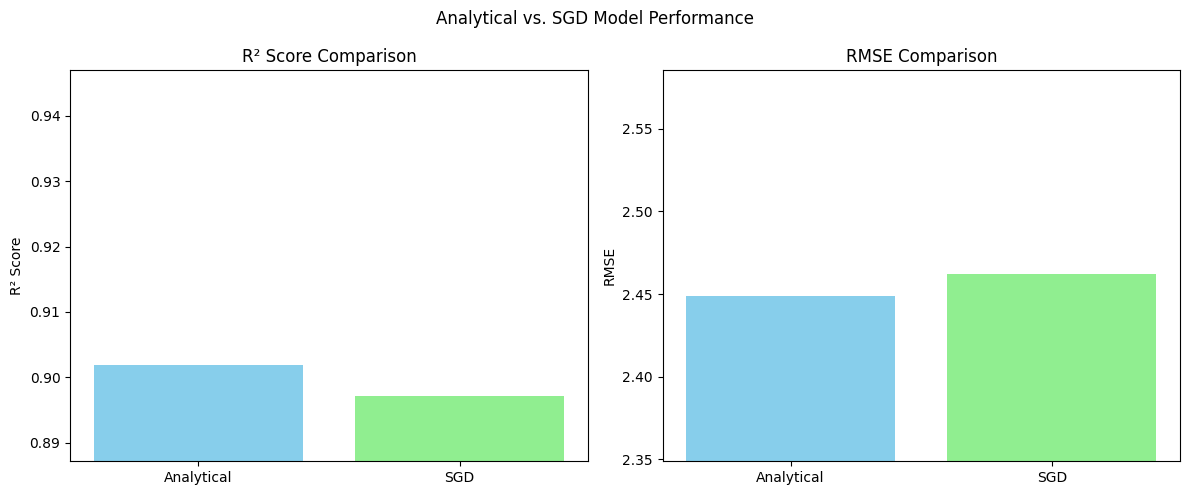

In [ ]:
model_names = ['Analytical', 'SGD']
r2_scores = [scores_analytical[0], scores_sgd[0]]
rmse_scores = [scores_analytical[1], scores_sgd[1]]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# R-squared Plot
axs[0].bar(model_names, r2_scores, color=['skyblue', 'lightgreen'])
axs[0].set_ylabel('R² Score')
axs[0].set_title('R² Score Comparison')
axs[0].set_ylim(bottom=min(r2_scores) - 0.01) # Adjust y-axis for better visibility

# RMSE Plot
axs[1].bar(model_names, rmse_scores, color=['skyblue', 'lightgreen'])
axs[1].set_ylabel('RMSE')
axs[1].set_title('RMSE Comparison')
axs[1].set_ylim(bottom=min(rmse_scores) - 0.1)

fig.suptitle('Analytical vs. SGD Model Performance')
plt.tight_layout()
plt.savefig('analytical_vs_sgd.png')

The analytical solution gives the theoretically optimal result for linear regression, but we can see that the SGD-based model converges to a solution that is nearly identical in performance.

So while the analytical solution is faster and more direct for smaller datasets, the SGD approach is a very effective method for larger datasets.

### Performance Relative to Regularization

In [ ]:
lambdas = [0, 0.01, 0.1, 1.0] # 0 - no regularization
learning_rates = [0.05, 0.01, 0.001]

results_r2 = np.zeros((len(lambdas), len(learning_rates)))

for i, l in enumerate(lambdas):
  for j, lr in enumerate(learning_rates):
    ## Collect train/test sets
    train_set, train_output, test_set, test_output = metrics.split_data(X_parkinsons, y_parkinsons, 0.2, seed=my_seed)

    ## Train model
    lin_model = LinearRegressionSGD(regularization='L2' if l > 0 else None, lamb=l, learning_rate = lr)
    lin_model.fit(train_set, train_output)

    y_pred_test = lin_model.predict(test_set)
    results_r2[i, j] = r2_score(test_output, y_pred_test)

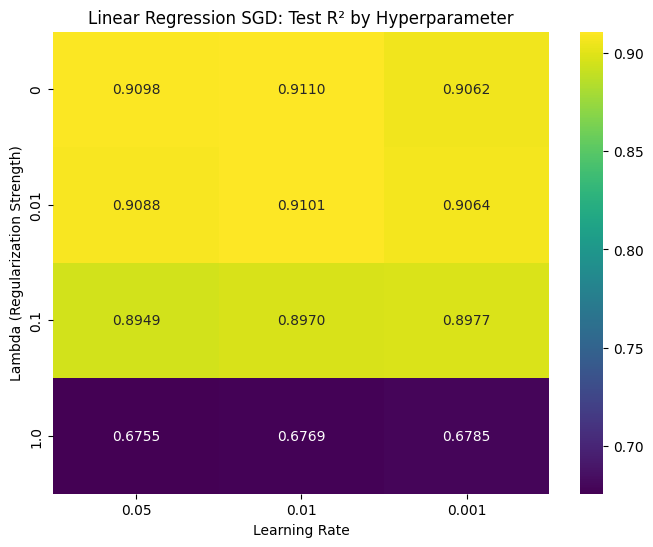

In [ ]:
# R^2 heatmap for each combination of lambda and lr

plt.figure(figsize=(8, 6))
sns.heatmap(results_r2, annot=True, fmt=".4f", cmap='viridis',
            xticklabels=learning_rates, yticklabels=lambdas)
plt.xlabel('Learning Rate')
plt.ylabel('Lambda (Regularization Strength)')
plt.title('Linear Regression SGD: Test R² by Hyperparameter')
plt.savefig('lr_hyperparameter_heatmap.png')

### Preformance Relative to Batch size:

Dataset: Parkinsons

Learning Rate: 0.005

epsilon: 0.01

batch sizes: 8, 16, 32, 64, 128, 256, 512, 1024, 2048, full batch

Train/test ratio: 80/20

In [ ]:
batch_sizes = [2**i for i in range(3, 10)]
batch_sizes.append(feat_parkinsons.shape[0]) ## Full batch
n_iterations = 10

performance_lin2 = np.zeros((2, 3, len(batch_sizes), n_iterations))
iter_convergence_lin2 = np.zeros((len(batch_sizes), n_iterations))

for j in range(n_iterations): ## 10 permutations

  ## Isolate training and test sets
  train_set, train_output, test_set, test_output = metrics.split_data(X_parkinsons, y_parkinsons, 0.2, seed=(my_seed+j))

  ## Try different batch sizes
  for i in range(len(batch_sizes)):
    batch_size = batch_sizes[i]

    ## Fit model
    lin_sgd_model = LinearRegressionSGD(batch_size=batch_size, max_iters=2000, epsilon=0.01, learning_rate=0.005)
    lin_sgd_model.fit(train_set, train_output)

    ## Collect how many iterations til convergence
    iter_convergence_lin2[i,j] = lin_sgd_model.convergence_iter

    ## Make prediction
    y_lin_train = lin_sgd_model.predict(train_set)
    y_lin_test = lin_sgd_model.predict(test_set)

    ## Evaluate
    performance_lin2[0,:,i,j] = metrics.get_metrics_regression(train_output, y_lin_train, print_metrics = False)
    performance_lin2[1,:,i,j] = metrics.get_metrics_regression(test_output, y_lin_test, print_metrics = False)


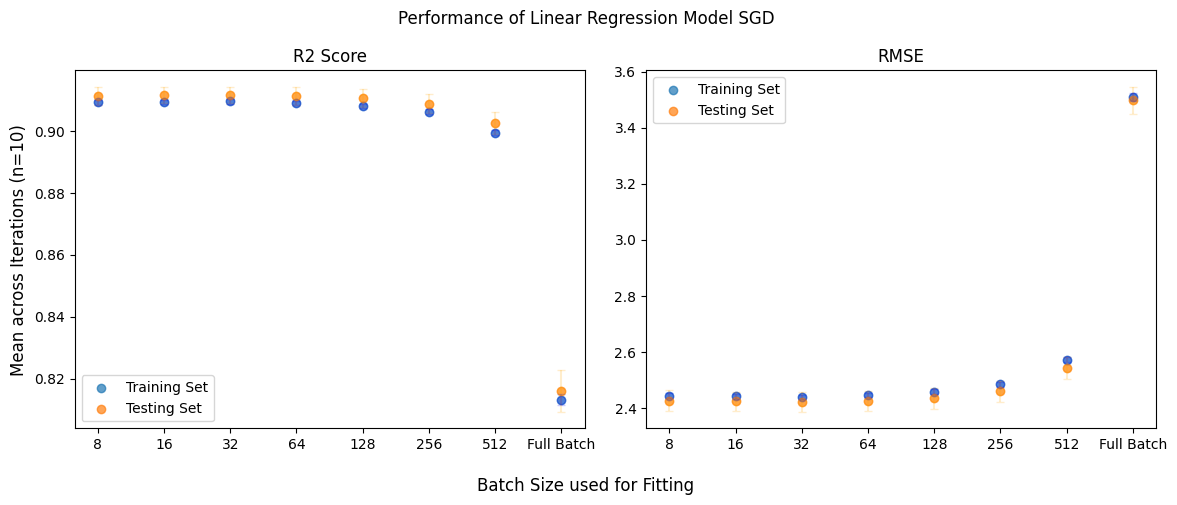

In [ ]:
## Plotting Preformance for Prediction Accuracy:
fig, axs = plt.subplots(1, 2, figsize=(12,5))
mets = ["R2 Score", "RMSE"]

batchs = batch_sizes[:-1]
batchs.append("Full Batch")

for i in range(2):
  ax = axs[i]
  met = i

  # Calculate mean and std accross the iterations
  train_mean = performance_lin2[0,met].mean(axis=1)
  train_std = performance_lin2[0,met].std(axis=1)

  test_mean = performance_lin2[1,met].mean(axis=1)
  test_std = performance_lin2[1,met].std(axis=1)

  # Plot
  ax.scatter([str(b) for b in batchs], train_mean, label="Training Set", alpha=0.7)
  ax.errorbar([str(b) for b in batchs], train_mean, yerr=train_std, fmt='o', color='blue', alpha=0.2, capsize=3)
  ax.scatter([str(b) for b in batchs], test_mean, label="Testing Set", alpha=0.7)
  ax.errorbar([str(b) for b in batchs], test_mean, yerr=test_std, fmt='o', color='orange', alpha=0.2, capsize=3)
  ax.set_title(mets[met])
  ax.legend()

fig.supylabel("Mean across Iterations (n=10)")
fig.supxlabel("Batch Size used for Fitting")
fig.suptitle("Performance of Linear Regression Model SGD")
fig.tight_layout()
fig.show()


/tmp/ipython-input-2995205334.py:18: RuntimeWarning: invalid value encountered in divide
  con_mean = np.where(nonzero_counts > 0, con_speed.sum(axis=1)/nonzero_counts, np.nan )
/tmp/ipython-input-2995205334.py:19: RuntimeWarning: invalid value encountered in divide
  con_std = np.where(nonzero_counts > 0, con_speed.std(axis=1)/np.sqrt(nonzero_counts), np.nan)


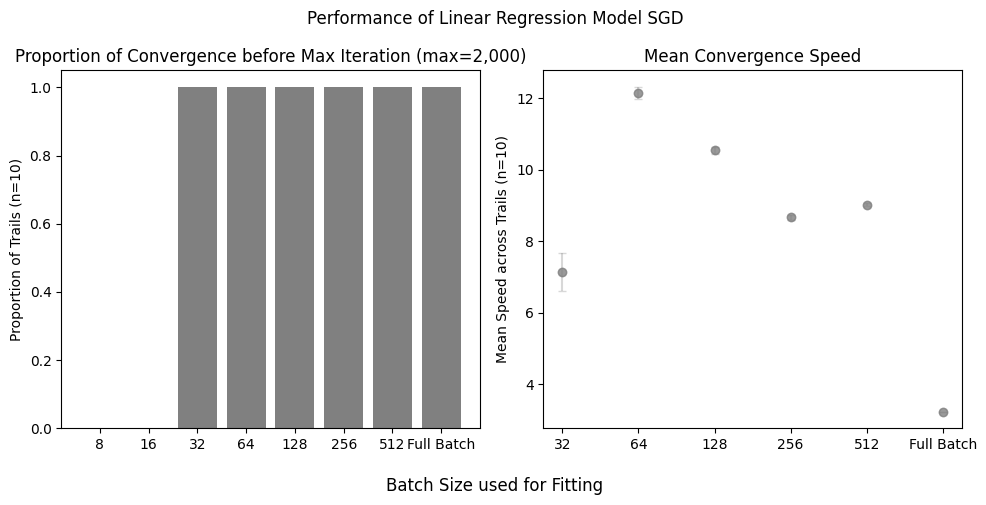

In [ ]:
## Ploting convergence
fig, ax = plt.subplots(1, 2, figsize=(10,5))

## Proportion of iterations that converged:
con_prop = iter_convergence_lin2 < lin_sgd_model.max_iters
con_prop = np.mean(con_prop, axis=1)

## Ploting Propotion Convergence:
ax[0].bar([str(b) for b in batchs], con_prop, color='grey')
ax[0].set_ylabel("Proportion of Trails (n=10)")
ax[0].set_title("Proportion of Convergence before Max Iteration (max=2,000)")

## Calculate speed
con_speed = lin_sgd_model.max_iters/iter_convergence_lin2 - 1

## Calculate mean speed and standard deviation (only takes into account iterations that converged)
nonzero_counts = (con_speed != 0).sum(axis=1)
con_mean = np.where(nonzero_counts > 0, con_speed.sum(axis=1)/nonzero_counts, np.nan )
con_std = np.where(nonzero_counts > 0, con_speed.std(axis=1)/np.sqrt(nonzero_counts), np.nan)

## Ploting convergence Speed:
ax[1].scatter([str(b) for b in batchs], con_mean, color='grey', alpha=0.7)
ax[1].errorbar([str(b) for b in batchs], con_mean, yerr=con_std, fmt='o', color='grey', alpha=0.3, capsize=3)
ax[1].set_title("Mean Convergence Speed")
ax[1].set_ylabel("Mean Speed across Trails (n=10)")

fig.supxlabel("Batch Size used for Fitting")
fig.suptitle("Performance of Linear Regression Model SGD")
fig.tight_layout()
fig.show()


### Preformance Relative to Learning Rate:

Dataset: Parkinsons

Learning Rates: 0.00001, 0.0001, 0.001, 0.01, 0.1

epsilon: 0.01

batch size: 32

Train/test ratio: 80/20

In [ ]:
learning_rates = [0.00001, 0.0001, 0.001, 0.01, 0.1]

n_iterations = 10
performance_lin3 = np.zeros((2, 3, len(learning_rates), n_iterations))
iter_convergence_lin3 = np.zeros((len(learning_rates), n_iterations))

## Isolate training and test sets
for j in range(n_iterations): ## 10 permutations
  train_set, train_output, test_set, test_output = metrics.split_data(X_parkinsons, y_parkinsons, 0.2, seed=(my_seed+j))

  for i in range(len(learning_rates)):
    rate = learning_rates[i]

    ## Fit model
    lin_sgd_model = LinearRegressionSGD(batch_size=32, max_iters=2000, epsilon=0.01, learning_rate=rate)
    lin_sgd_model.fit(train_set, train_output)

    ## Convergence Time
    iter_convergence_lin3[i,j] = lin_sgd_model.convergence_iter

    ## Make prediction
    y_lin_train = lin_sgd_model.predict(train_set)
    y_lin_test = lin_sgd_model.predict(test_set)

    ## Evaluate
    performance_lin3[0,:,i,j] = metrics.get_metrics_regression(train_output, y_lin_train, print_metrics = False)
    performance_lin3[1,:,i,j] = metrics.get_metrics_regression(test_output, y_lin_test, print_metrics = False)

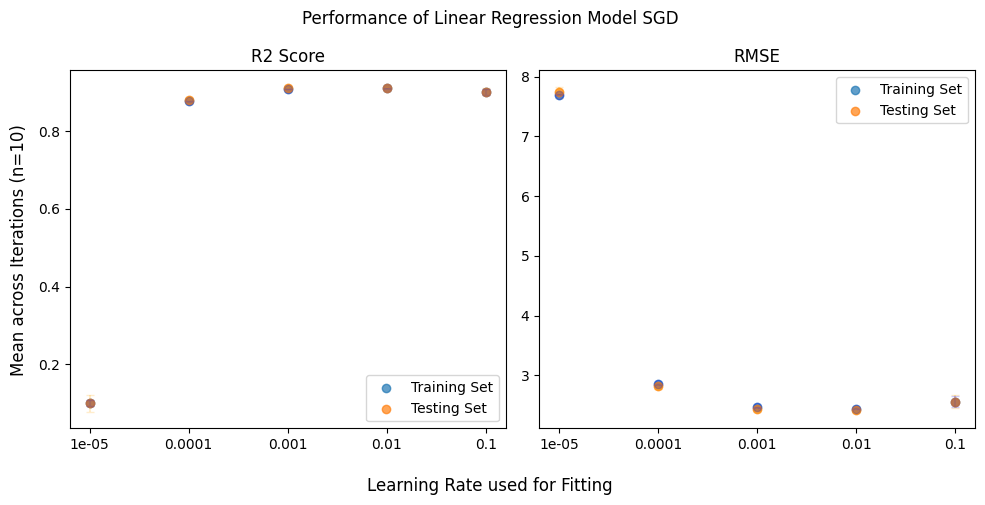

In [ ]:
## Plotting Preformance for Prediction Accuracy:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
mets = ["R2 Score", "RMSE"]

for i in range(2):
  ax = axs[i]
  met = i

  # Calculate mean and std accross the iterations
  train_mean = performance_lin3[0,met].mean(axis=1)
  train_std = performance_lin3[0,met].std(axis=1)

  test_mean = performance_lin3[1,met].mean(axis=1)
  test_std = performance_lin3[1,met].std(axis=1)

  # Plot
  ax.scatter([str(r) for r in learning_rates], train_mean, label="Training Set", alpha=0.7)
  ax.errorbar([str(r) for r in learning_rates], train_mean, yerr=train_std, fmt='o', color='blue', alpha=0.2, capsize=3)
  ax.scatter([str(r) for r in learning_rates], test_mean, label="Testing Set", alpha=0.7)
  ax.errorbar([str(r) for r in learning_rates], test_mean, yerr=test_std, fmt='o', color='orange', alpha=0.2, capsize=3)
  ax.set_title(mets[met])
  ax.legend()

fig.supylabel("Mean across Iterations (n=10)")
fig.supxlabel("Learning Rate used for Fitting")
fig.suptitle("Performance of Linear Regression Model SGD")
fig.tight_layout()
fig.show()

/tmp/ipython-input-3345478138.py:19: RuntimeWarning: invalid value encountered in divide
  con_mean = np.where(nonzero_counts > 0, con_speed.sum(axis=1)/nonzero_counts, np.nan )
/tmp/ipython-input-3345478138.py:20: RuntimeWarning: invalid value encountered in divide
  con_std = np.where(nonzero_counts > 0, con_speed.std(axis=1)/np.sqrt(nonzero_counts), np.nan)


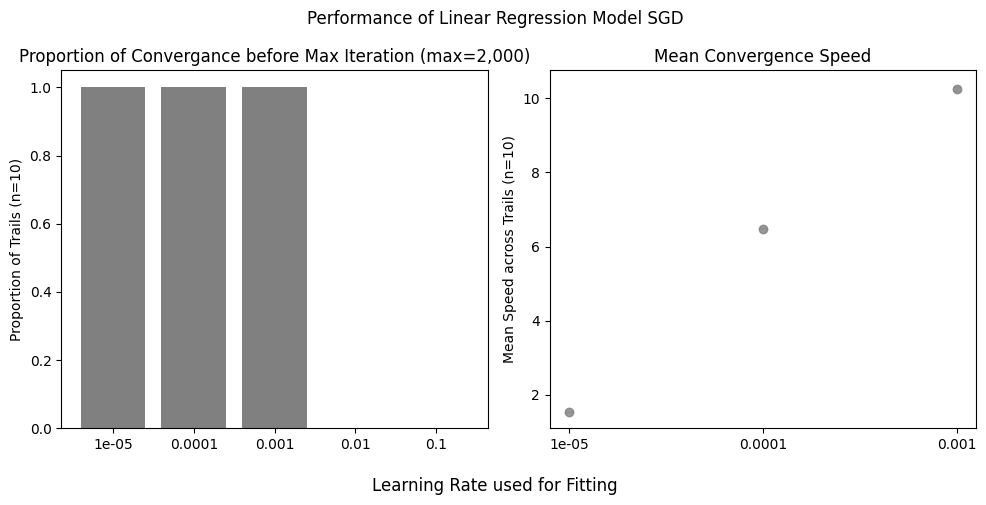

In [ ]:
## Plotting Convergence

fig, ax = plt.subplots(1, 2, figsize=(10,5))

## Proportion of iterations that converged
con_prop = iter_convergence_lin3 < lin_sgd_model.max_iters
con_prop = np.mean(con_prop, axis=1)

## Plotting Propotion Convergence:
ax[0].bar([str(r) for r in learning_rates], con_prop, color='grey')
ax[0].set_ylabel("Proportion of Trails (n=10)")
ax[0].set_title("Proportion of Convergance before Max Iteration (max=2,000)")

## Calculate speed
con_speed = lin_sgd_model.max_iters/iter_convergence_lin3 - 1

## Calculate mean speed and standard deviation (only takes into account iterations that converged)
nonzero_counts = (con_speed != 0).sum(axis=1)
con_mean = np.where(nonzero_counts > 0, con_speed.sum(axis=1)/nonzero_counts, np.nan )
con_std = np.where(nonzero_counts > 0, con_speed.std(axis=1)/np.sqrt(nonzero_counts), np.nan)

## Plotting Convergence Speed:
ax[1].scatter([str(r) for r in learning_rates], con_mean, color='grey', alpha=0.7)
ax[1].errorbar([str(r) for r in learning_rates], con_mean, yerr=con_std, fmt='o', color='grey', alpha=0.3, capsize=3)
ax[1].set_title("Mean Convergence Speed")
ax[1].set_ylabel("Mean Speed across Trails (n=10)")

fig.supxlabel("Learning Rate used for Fitting")
fig.suptitle("Performance of Linear Regression Model SGD")
fig.tight_layout()
fig.show()

### Adding Polynomial Features

In [ ]:
n_iterations = 5

basic_r2_scores = np.zeros(n_iterations)
basic_rmse_scores = np.zeros(n_iterations)
poly_r2_scores = np.zeros(n_iterations)
poly_rmse_scores = np.zeros(n_iterations)

for i in range(n_iterations):
  X_train, y_train, X_test, y_test = metrics.split_data(X_parkinsons, y_parkinsons, 0.2, seed=my_seed+i+551)

  # SGD Linear Regression Model
  basic_model = LinearRegressionSGD(learning_rate=0.005)
  basic_model.fit(X_train, y_train)
  y_pred_basic = basic_model.predict(X_test)

  basic_metrics = metrics.get_metrics_regression(y_test, y_pred_basic, print_metrics=False)
  basic_r2_scores[i] = basic_metrics[0]
  basic_rmse_scores[i] = basic_metrics[1]

  # polynomial SGD Linear Regression Model
  X_train_poly = create_polynomial_features(X_train)
  X_test_poly = create_polynomial_features(X_test)

  # have to add this scaler, bc polynomial feautures can be very large values and the SGD model is very sensitive to scale
  poly_scaler = StandardScaler()
  X_train_poly_scaled = poly_scaler.fit_transform(X_train_poly)
  X_test_poly_scaled = poly_scaler.transform(X_test_poly)

  poly_model = LinearRegressionSGD(learning_rate=0.005)
  poly_model.fit(X_train_poly_scaled, y_train)
  y_pred_poly = poly_model.predict(X_test_poly_scaled)
  poly_metrics = metrics.get_metrics_regression(y_test, y_pred_poly, print_metrics=False)
  poly_r2_scores[i] = poly_metrics[0]
  poly_rmse_scores[i] = poly_metrics[1]

Basic Model Avg. R^2:   0.9098 (+- 0.0042)
Basic Model Avg. RMSE: 2.4423 (+- 0.0523)

Poly. Model Avg. R^2:   0.9441 (+- 0.0041)
Poly. Model Avg. RMSE: 1.9210 (+- 0.0639)


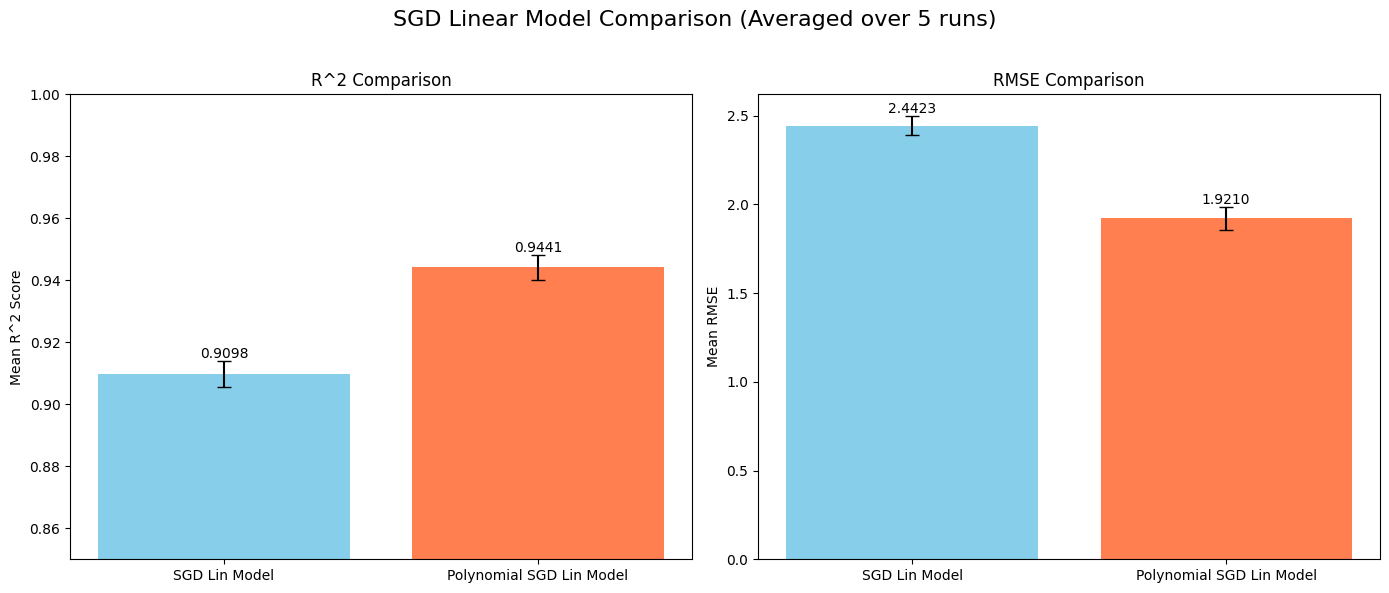

In [ ]:
print(f"Basic Model Avg. R^2:   {np.mean(basic_r2_scores):.4f} (+- {np.std(basic_r2_scores):.4f})")
print(f"Basic Model Avg. RMSE: {np.mean(basic_rmse_scores):.4f} (+- {np.std(basic_rmse_scores):.4f})\n")
print(f"Poly. Model Avg. R^2:   {np.mean(poly_r2_scores):.4f} (+- {np.std(poly_r2_scores):.4f})")
print(f"Poly. Model Avg. RMSE: {np.mean(poly_rmse_scores):.4f} (+- {np.std(poly_rmse_scores):.4f})")

model_names = ['SGD Lin Model', 'Polynomial SGD Lin Model']
mean_r2 = [np.mean(basic_r2_scores), np.mean(poly_r2_scores)]
std_r2 = [np.std(basic_r2_scores), np.std(poly_r2_scores)]
mean_rmse = [np.mean(basic_rmse_scores), np.mean(poly_rmse_scores)]
std_rmse = [np.std(basic_rmse_scores), np.std(poly_rmse_scores)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
bars1 = ax1.bar(model_names, mean_r2, yerr=std_r2, color=['skyblue', 'coral'], capsize=5)
ax1.bar_label(bars1, fmt='%.4f')
ax1.set_ylabel('Mean R^2 Score')
ax1.set_title('R^2 Comparison')
ax1.set_ylim(bottom=0.85, top=1.0)

bars2 = ax2.bar(model_names, mean_rmse, yerr=std_rmse, color=['skyblue', 'coral'], capsize=5)
ax2.bar_label(bars2, fmt='%.4f')
ax2.set_ylabel('Mean RMSE')
ax2.set_title('RMSE Comparison')
fig.suptitle(f'SGD Linear Model Comparison (Averaged over {n_iterations} runs)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('SGD_linear_comparison_plot_custom_metrics.png')

## Logistic Regression with SGD


### Performance Relative to Regularization

In [ ]:
lambdas = [0, 0.01, 0.1, 1.0] # 0 - no regularization
learning_rates = [0.05, 0.01, 0.001]

results_acc = np.zeros((len(lambdas), len(learning_rates)))

for i, l in enumerate(lambdas):
  for j, lr in enumerate(learning_rates):
    ## Collect train/test sets
    train_set, train_output, test_set, test_output = metrics.split_data(X_cancer, y_cancer, 0.2, seed=my_seed)

    ## Train model
    lin_model = LogisticRegressionSGD(regularization='L2' if l > 0 else None, lamb=l, learning_rate = lr)
    lin_model.fit(train_set, train_output)

    y_pred_test = lin_model.predict(test_set)
    results_acc[i, j] = accuracy_score(test_output, y_pred_test)

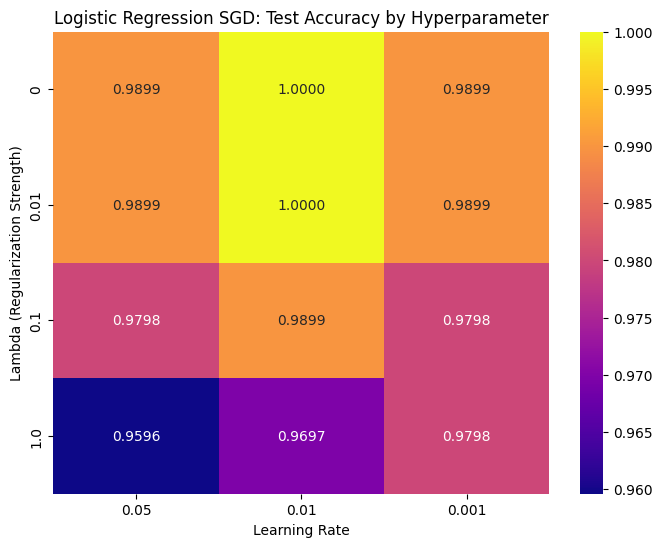

In [ ]:
# accuracy heatmap for each combination of lambda and lr

plt.figure(figsize=(8, 6))
sns.heatmap(results_acc, annot=True, fmt=".4f", cmap='plasma',
            xticklabels=learning_rates, yticklabels=lambdas)
plt.xlabel('Learning Rate')
plt.ylabel('Lambda (Regularization Strength)')
plt.title('Logistic Regression SGD: Test Accuracy by Hyperparameter')
plt.savefig('log_hyperparameter_heatmap.png')

### Preformance Relative to Batch size:


Dataset: Breast Cancer

Learning Rate: 0.005

epsilon: 0.001

batch sizes: 8, 16, 32, 64, 128, 256, full batch

Train/test ratio: 80/2

In [ ]:
batch_sizes = [2**i for i in range(3, 9)]
batch_sizes.append(X_cancer.shape[0]) # Full batch
n_iterations = 10
performance_log2 = np.zeros((2, 4, len(batch_sizes),10))
iter_convergence_log2 = np.zeros((len(batch_sizes),10))

## Isolate training and test sets
for j in range(n_iterations):
  train_set, train_output, test_set, test_output = metrics.split_data(X_cancer, y_cancer, 0.2, seed=(my_seed+j)) ## 10 permutations

  for i in range(len(batch_sizes)):
    batch_size = batch_sizes[i]

    ## Fit model
    log_sgd_model = LogisticRegressionSGD(batch_size=batch_size, max_iters=2000, learning_rate=0.005, epsilon=0.001)
    log_sgd_model.fit(train_set, train_output)

    ## Convergence Time
    iter_convergence_log2[i,j] = log_sgd_model.convergence_iter

    ## Make prediction
    y_log_train = log_sgd_model.predict(train_set)
    y_log_test = log_sgd_model.predict(test_set)

    ## Evaluate
    performance_log2[0,:,i,j] = metrics.get_metrics_classification(train_output, y_log_train, print_metrics = False)
    performance_log2[1,:,i,j] = metrics.get_metrics_classification(test_output, y_log_test, print_metrics = False)

Converged after 1250 iterations
Converged after 919 iterations
Converged after 725 iterations
Converged after 658 iterations
Converged after 500 iterations
Converged after 376 iterations
Converged after 1235 iterations
Converged after 945 iterations
Converged after 721 iterations
Converged after 605 iterations
Converged after 524 iterations
Converged after 395 iterations
Converged after 1213 iterations
Converged after 905 iterations
Converged after 743 iterations
Converged after 624 iterations
Converged after 526 iterations
Converged after 393 iterations
Converged after 1885 iterations
Converged after 1178 iterations
Converged after 870 iterations
Converged after 716 iterations
Converged after 550 iterations
Converged after 490 iterations
Converged after 373 iterations
Converged after 1150 iterations
Converged after 887 iterations
Converged after 706 iterations
Converged after 595 iterations
Converged after 492 iterations
Converged after 379 iterations
Converged after 1251 iterations
C

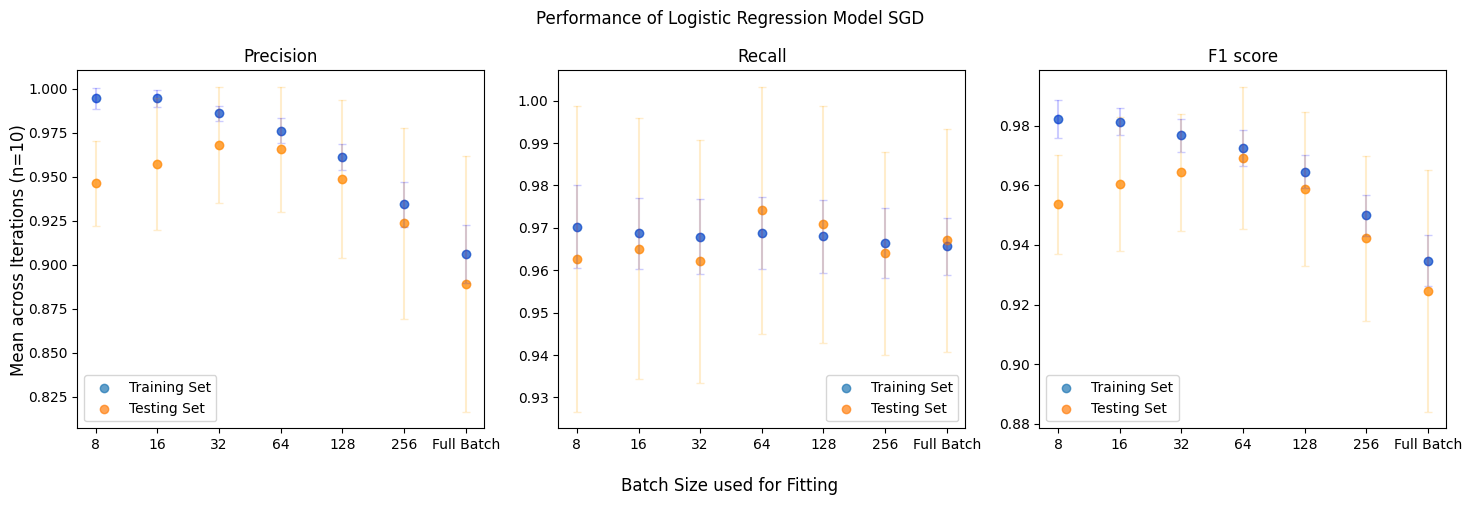

In [ ]:
## Plotting Preformance for Prediction Accuracy:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
mets = ["Precision","Recall","F1 score"]

batchs = batch_sizes[:-1]
batchs.append("Full Batch")

for i in range(3):
  ax = axs[i]
  met = i

  # Calculate mean and std accross the iterations
  train_mean = performance_log2[0,met].mean(axis=1)
  train_std = performance_log2[0,met].std(axis=1)

  test_mean = performance_log2[1,met].mean(axis=1)
  test_std = performance_log2[1,met].std(axis=1)

  # Plot
  ax.scatter([str(b) for b in batchs], train_mean, label="Training Set", alpha=0.7)
  ax.errorbar([str(b) for b in batchs], train_mean, yerr=train_std, fmt='o', color='blue', alpha=0.2, capsize=3)
  ax.scatter([str(b) for b in batchs], test_mean, label="Testing Set", alpha=0.7)
  ax.errorbar([str(b) for b in batchs], test_mean, yerr=test_std, fmt='o', color='orange', alpha=0.2, capsize=3)
  ax.set_title(mets[met])
  ax.legend()

fig.supylabel("Mean across Iterations (n=10)")
fig.supxlabel("Batch Size used for Fitting")
fig.suptitle("Performance of Logistic Regression Model SGD")
fig.tight_layout()
fig.show()


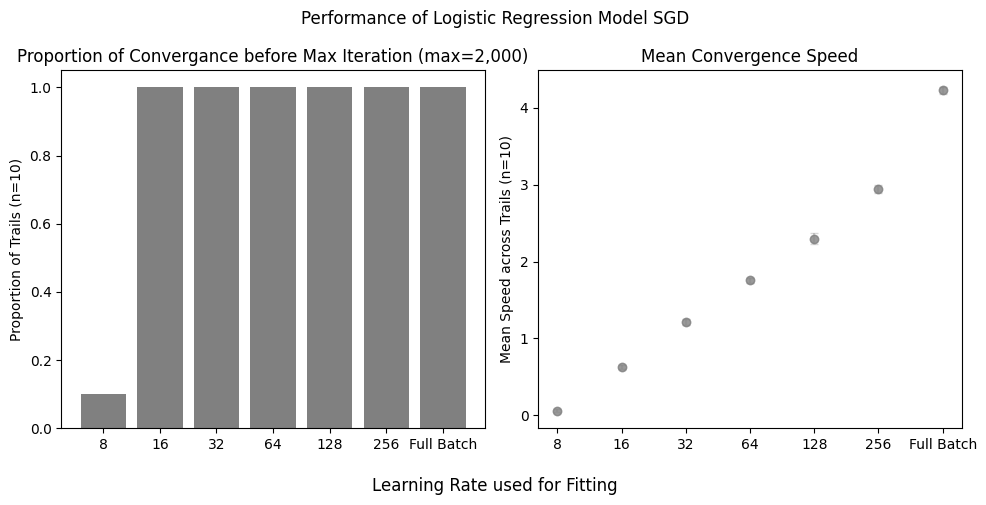

In [ ]:
## Plotting Convergence
fig, ax = plt.subplots(1, 2, figsize=(10,5))

## Proportion of iterations that converged:
con_prop = iter_convergence_log2 < log_sgd_model.max_iters
con_prop = np.mean(con_prop, axis=1)

## Plotting Propotion Convergence:
ax[0].bar([str(b) for b in batchs], con_prop, color='grey')
ax[0].set_ylabel("Proportion of Trails (n=10)")
ax[0].set_title("Proportion of Convergance before Max Iteration (max=2,000)")

## Calculate speed
con_speed = log_sgd_model.max_iters/iter_convergence_log2 - 1

## Calculate mean speed and standard deviation (only takes into account iterations that converged)
nonzero_counts = (con_speed != 0).sum(axis=1)
con_mean = np.where(nonzero_counts > 0, con_speed.sum(axis=1)/nonzero_counts, np.nan )
con_std = np.where(nonzero_counts > 0, con_speed.std(axis=1)/np.sqrt(nonzero_counts), np.nan)

## Plotting Convergence Speed:
ax[1].scatter([str(b) for b in batchs], con_mean, color='grey', alpha=0.7)
ax[1].errorbar([str(b) for b in batchs], con_mean, yerr=con_std, fmt='o', color='grey', alpha=0.3, capsize=3)
ax[1].set_title("Mean Convergence Speed")
ax[1].set_ylabel("Mean Speed across Trails (n=10)")

fig.supxlabel("Learning Rate used for Fitting")
fig.suptitle("Performance of Logistic Regression Model SGD")
fig.tight_layout()
fig.show()

### Preformance Relative to Learning Rate:

Dataset: Breast Cancer

Learning Rates: 0.00001, 0.0001, 0.001, 0.01, 0.1

epsilon: 0.001

batch size: 16

Train/test ratio: 80/20

In [ ]:
learning_rates = [0.0005, 0.0001, 0.001, 0.01, 0.1]

n_iterations = 10

performance_log3 = np.zeros((2, 4, len(learning_rates), n_iterations))
iter_convergence_log3 = np.zeros((len(learning_rates), n_iterations))

## Isolate training and test sets
for j in range(n_iterations):
  train_set, train_output, test_set, test_output = metrics.split_data(X_cancer, y_cancer, 0.2, seed=(my_seed+j)) ## 10 permutations

  for i in range(len(learning_rates)):
    rate = learning_rates[i]

    ## Fit model
    log_sgd_model = LogisticRegressionSGD(batch_size=16, max_iters=2000, learning_rate=rate, epsilon=0.001)
    log_sgd_model.fit(train_set, train_output)

    ## Convergence Time
    iter_convergence_log3[i,j] = log_sgd_model.convergence_iter

    ## Make prediction
    y_log_train = log_sgd_model.predict(train_set)
    y_log_test = log_sgd_model.predict(test_set)

    ## Evaluate
    performance_log3[0,:,i,j] = metrics.get_metrics_classification(train_output, y_log_train, print_metrics = False)
    performance_log3[1,:,i,j] = metrics.get_metrics_classification(test_output, y_log_test, print_metrics = False)

Converged after 572 iterations
Converged after 267 iterations
Converged after 722 iterations
Converged after 584 iterations
Converged after 283 iterations
Converged after 728 iterations
Converged after 572 iterations
Converged after 281 iterations
Converged after 694 iterations
Converged after 549 iterations
Converged after 275 iterations
Converged after 694 iterations
Converged after 1874 iterations
Converged after 559 iterations
Converged after 276 iterations
Converged after 708 iterations
Converged after 563 iterations
Converged after 279 iterations
Converged after 704 iterations
Converged after 610 iterations
Converged after 287 iterations
Converged after 782 iterations
Converged after 556 iterations
Converged after 271 iterations
Converged after 695 iterations
Converged after 564 iterations
Converged after 268 iterations
Converged after 686 iterations
Converged after 537 iterations
Converged after 277 iterations
Converged after 669 iterations


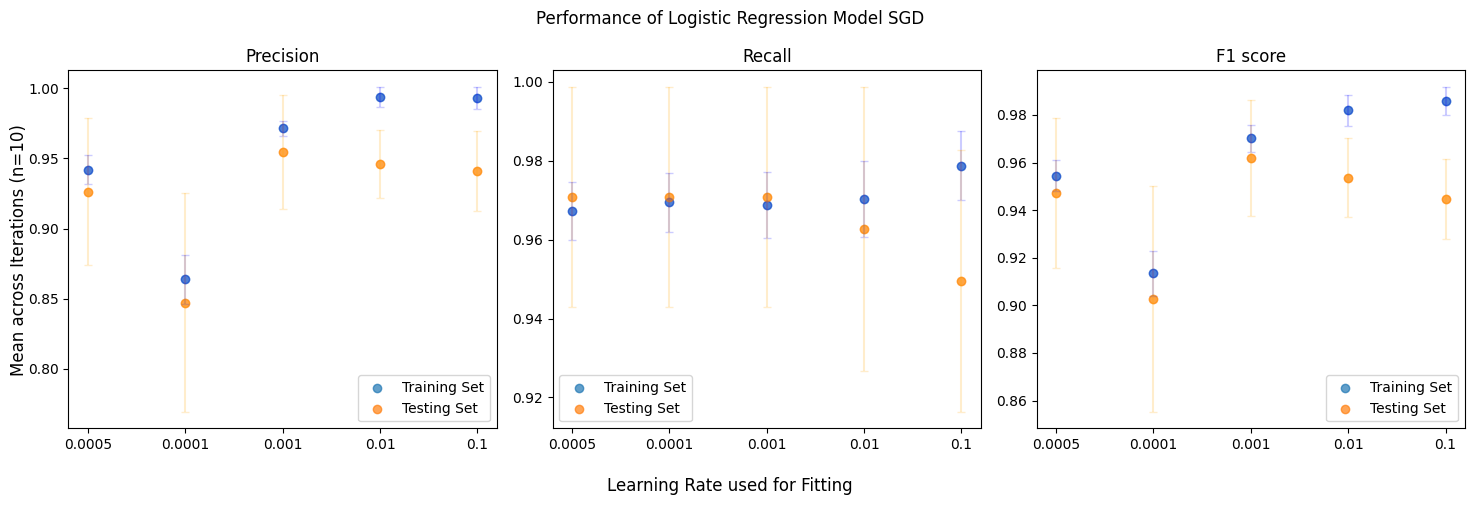

In [ ]:
## Plotting Preformance

fig, axs = plt.subplots(1, 3, figsize=(15,5))
mets = ["Precision","Recall","F1 score"]

for i in range(3):
  ax = axs[i]
  met = i

  # Calculate mean and std accross the iterations
  train_mean = performance_log3[0,met].mean(axis=1)
  train_std = performance_log3[0,met].std(axis=1)

  test_mean = performance_log3[1,met].mean(axis=1)
  test_std = performance_log3[1,met].std(axis=1)

  # Plot
  ax.scatter([str(r) for r in learning_rates], train_mean, label="Training Set", alpha=0.7)
  ax.errorbar([str(r) for r in learning_rates], train_mean, yerr=train_std, fmt='o', color='blue', alpha=0.2, capsize=3)
  ax.scatter([str(r) for r in learning_rates], test_mean, label="Testing Set", alpha=0.7)
  ax.errorbar([str(r) for r in learning_rates], test_mean, yerr=test_std, fmt='o', color='orange', alpha=0.2, capsize=3)
  ax.set_title(mets[met])
  ax.legend()

fig.supylabel("Mean across Iterations (n=10)")
fig.supxlabel("Learning Rate used for Fitting")
fig.suptitle("Performance of Logistic Regression Model SGD")
fig.tight_layout()
fig.show()

/tmp/ipython-input-658008266.py:18: RuntimeWarning: invalid value encountered in divide
  con_mean = np.where(nonzero_counts > 0, con_speed.sum(axis=1)/nonzero_counts, np.nan )
/tmp/ipython-input-658008266.py:19: RuntimeWarning: invalid value encountered in divide
  con_std = np.where(nonzero_counts > 0, con_speed.std(axis=1)/np.sqrt(nonzero_counts), np.nan)


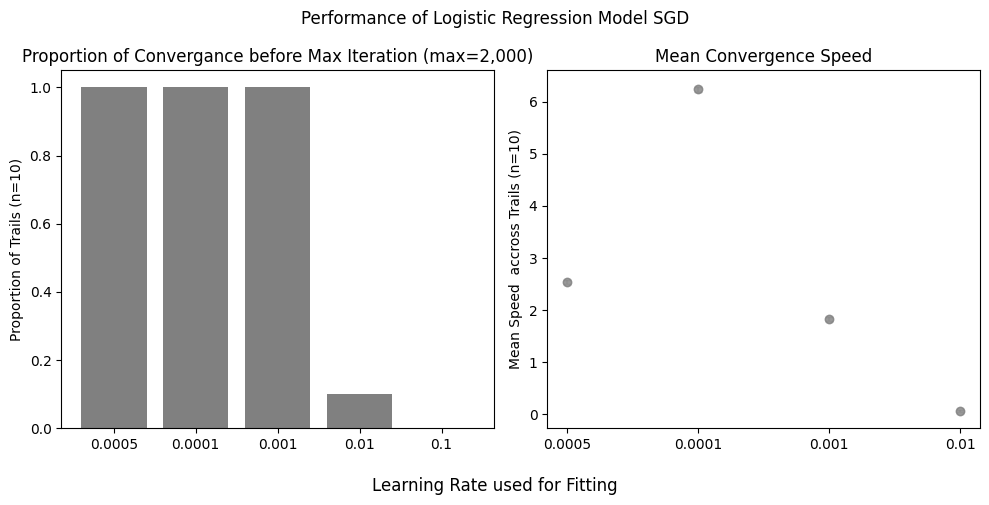

In [ ]:
## Plotting Convergence
fig, ax = plt.subplots(1, 2, figsize=(10,5))

## Proportion of iterations that converged:
con_prop = iter_convergence_log3 < log_sgd_model.max_iters
con_prop = np.mean(con_prop, axis=1)

## Plotting Propotion Convergence:
ax[0].bar([str(r) for r in learning_rates], con_prop, color='grey')
ax[0].set_ylabel("Proportion of Trails (n=10)")
ax[0].set_title("Proportion of Convergance before Max Iteration (max=2,000)")

## Calculate speed
con_speed = log_sgd_model.max_iters/iter_convergence_log3 - 1

## Calculate mean speed and standard deviation (only takes into account iterations that converged)
nonzero_counts = (con_speed != 0).sum(axis=1)
con_mean = np.where(nonzero_counts > 0, con_speed.sum(axis=1)/nonzero_counts, np.nan )
con_std = np.where(nonzero_counts > 0, con_speed.std(axis=1)/np.sqrt(nonzero_counts), np.nan)

## Plotting Convergence Speed:
ax[1].scatter([str(r) for r in learning_rates], con_mean, color='grey', alpha=0.7)
ax[1].errorbar([str(r) for r in learning_rates], con_mean, yerr=con_std, fmt='o', color='grey', alpha=0.3, capsize=3)
ax[1].set_title("Mean Convergence Speed")
ax[1].set_ylabel("Mean Speed  accross Trails (n=10)")

fig.supxlabel("Learning Rate used for Fitting")
fig.suptitle("Performance of Logistic Regression Model SGD")
fig.tight_layout()
fig.show()

### Adding Polynomial Features

In [ ]:
n_iterations = 5

basic_accuracies = np.zeros(n_iterations)
poly_accuracies = np.zeros(n_iterations)

for i in range(n_iterations):
  X_train, y_train, X_test, y_test = metrics.split_data(X_cancer, y_cancer, 0.2, seed=my_seed+i)

  # SGD Logistic Regression Model
  basic_model = LogisticRegressionSGD()
  basic_model.fit(X_train, y_train)
  y_pred_basic = basic_model.predict(X_test)
  basic_accuracies[i] = accuracy_score(y_test, y_pred_basic)

  # polynomial Logistic Regression Model
  X_train_poly = create_polynomial_features(X_train)
  X_test_poly = create_polynomial_features(X_test)

  poly_model = LogisticRegressionSGD()
  poly_model.fit(X_train_poly, y_train)
  y_pred_poly = poly_model.predict(X_test_poly)
  poly_accuracies[i] = accuracy_score(y_test, y_pred_poly)

SGD Model Average Accuracy: 0.9717 (+- 0.0076)
Polynomial Model Average Accuracy: 0.9636 (+- 0.0208)


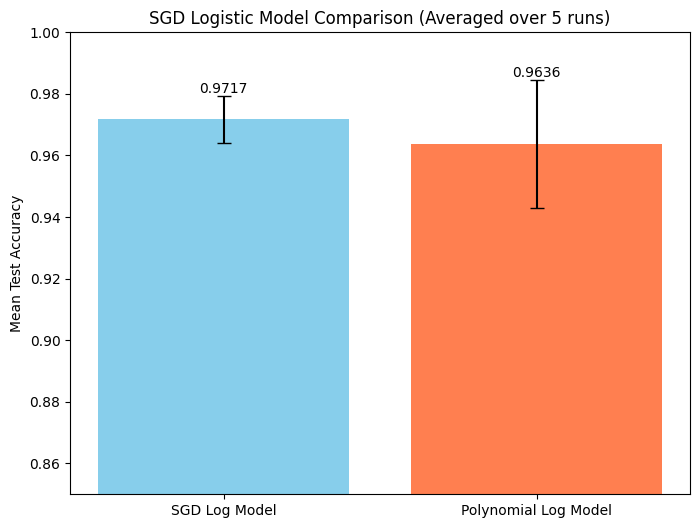

In [ ]:
mean_basic_acc = np.mean(basic_accuracies)
std_basic_acc = np.std(basic_accuracies)

mean_poly_acc = np.mean(poly_accuracies)
std_poly_acc = np.std(poly_accuracies)

print(f"SGD Model Average Accuracy: {mean_basic_acc:.4f} (+- {std_basic_acc:.4f})")
print(f"Polynomial Model Average Accuracy: {mean_poly_acc:.4f} (+- {std_poly_acc:.4f})")

model_names = ['SGD Log Model', 'Polynomial Log Model']
mean_accuracies = [mean_basic_acc, mean_poly_acc]
std_accuracies = [std_basic_acc, std_poly_acc]

plt.figure(figsize=(8, 6))
# https://matplotlib.org/stable/gallery/color/named_colors.html (cool colors ref)
bars = plt.bar(model_names, mean_accuracies, yerr=std_accuracies, color=['skyblue', 'coral'], capsize=5)

plt.ylabel('Mean Test Accuracy')
plt.title(f'SGD Logistic Model Comparison (Averaged over {n_iterations} runs)')
plt.ylim(bottom=0.85, top=1)
plt.bar_label(bars, fmt='%.4f')
plt.savefig('SGD_logistic_comparison_plot.png')